---
# <center> Nonparametric plug-in classifier for multiclass classification of S.D.E. paths

#### <center> Benjamin DAHAN MONSONEGO
---

##Libraries

In [ ]:
import subprocess
import sys
import importlib

def install_package(package_name):
    try:
        # Try to import the package
        __import__(package_name.split('[')[0].split('>=')[0].split('==')[0])
        print(f"{package_name} is already installed.")
    except ImportError:
        # If the import fails, install the package
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
        print(f"{package_name} has been installed.")

#!pip install "ray[tune]" torch torchvision pytorch_lightning
packages = [
    'ray[tune]',
    'lightning'
]
for package in packages:
    install_package(package)

ray[tune] has been installed.
lightning has been installed.


In [ ]:
import numpy as np
import pandas as pd
from scipy.linalg import pinv
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
from sklearn.preprocessing import PolynomialFeatures
from tqdm import tqdm
import random
import time
from numpy.linalg import pinv, det
from scipy.optimize import root
from sklearn.linear_model import Ridge
import rpy2.robjects as ro
import os
import pyarrow.feather as feather
import h5py
from sklearn.model_selection import train_test_split

In [ ]:
import lightning as L
import lightning.pytorch as pl
from lightning.pytorch.strategies import DDPStrategy
from lightning.pytorch.callbacks import ModelCheckpoint

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.cuda.amp import autocast, GradScaler
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import MNIST

import tensorflow as tf

from ray.train.lightning import (
    RayDDPStrategy,
    RayLightningEnvironment,
    RayTrainReportCallback,
    prepare_trainer,
)
from ray import tune
from ray.tune.schedulers import ASHAScheduler
from ray.train.torch import TorchTrainer
from ray.air import ScalingConfig, RunConfig, CheckpointConfig

import os



## Homogenous Model

###Useful Functions

In [ ]:
PATH = os.getcwd()

In [ ]:
def zfun(
    Mx : np.ndarray,
    delta : float
    )-> np.ndarray :
################################################################################
################################################################################
#### Function used to compute the succesive differences of order 1
####
#### Mx : Data matrix, containing sampled trajectories along rows.
#### Delta : TimeStep used to normalize the differences
################################################################################
################################################################################
    diffs = np.diff(Mx, axis=0)
    #result = (diffs[1:, :] / delta).flatten(order='F')
    result = (diffs / delta).flatten(order='F')
    #print("iZ shape : ",result.shape)
    return result
                          ###########################

def ufun(
    Mx : np.ndarray,
    delta : float
    )-> np.ndarray :
################################################################################
################################################################################
#### Computes the succesive differences of order 2
####
#### Mx : Data matrix, containing sampled trajectories along rows.
#### Delta : TimeStep used to normalize the differences
################################################################################
################################################################################
    diffs = np.diff(Mx, axis=0)**2
    #result = (diffs[1:, :] / delta).flatten(order='F')
    result = (diffs / delta).flatten(order='F')
    #print("U shape : ",result.shape)
    return result

                          ###########################

def labfun(
    x : np.ndarray,
    Inf_bound : float,
    Sup_bound : float
    )-> np.ndarray :
################################################################################
################################################################################
#### Checks if every coordinate of a trajectory is within
#### a specified interval [Inf_bound,Sup_bound]
####
#### x : Observed trajectory
#### Inf_bound : Lower bound
#### Sup_bound : Higher bound
################################################################################
################################################################################
    return np.array([(Inf_bound <= a)*(a <= Sup_bound) for a in x])

                          ###########################

def boundfun(
    x : np.ndarray,
    Inf_bound : float,
    Sup_bound : float
    )-> np.ndarray :
################################################################################
################################################################################
#### Replaces every coordinate of x that is outside of [Inf_bound,Sup_bound]
#### by Inf_bound
####
#### x : Observed trajectory
#### Inf_bound : Lower bound
#### Sup_bound : Higher bound
################################################################################
################################################################################
    return np.array([(a-Inf_bound)*(Inf_bound <= a)*(a <= Sup_bound) + Inf_bound for a in x])

                          ###########################

def create_bspline_basis(rangeval, nbasis, degree):
    knots = np.linspace(rangeval[0], rangeval[1], nbasis - degree + 1)
    knots = np.concatenate(([rangeval[0]] * degree, knots, [rangeval[1]] * degree))
    return BSpline(knots, np.eye(nbasis), degree)

def bspline(x, InfInt, SupInt, K, M):
    y = boundfun(x, InfInt, SupInt)
    id_matrix = np.diag(labfun(x, InfInt, SupInt))
    dm = K + M
    bs_basis = create_bspline_basis(rangeval=(InfInt, SupInt), nbasis=dm, degree = M)
    v_basis = bs_basis(y)
    print("Dimension of id_matrix:", id_matrix.shape)
    print("Dimension of v_basis:", v_basis.shape)
    if len(id_matrix) != 0:
        result = np.dot(id_matrix, v_basis)
    else:
        result = np.zeros_like(v_basis)
    return result

                          ###########################

def bfun(
    Mx : np.ndarray,
    Inf_bound : float,
    Sup_bound : float,
    K : int,
    M: int
    )-> np.ndarray:
################################################################################
################################################################################
#### Creates the B-Spline matrix B = (B^j(X_i))_{i,j} in R^{N.n,K+M}
####
#### Mx : Matrix of observed trajectories
#### Inf_bound : Lower bound
#### Sup_bound : Higher bound
#### K : Number of non zero knots
#### M : Such that K+M = desired number of B-Spline functions
################################################################################
################################################################################
    print("K value in bfun :",K)
    #df_X = Mx
    N = Mx.shape[1]
    n = Mx.shape[0]
    matrix_B = np.zeros((N*n,K+M))
    for i in tqdm(range(N),desc='Loop over observations'):
            matrix_B[i*n:(i+1)*n,:] = bspline(Mx[:,i], Inf_bound, Sup_bound, K, M)
    return matrix_B

                          ###########################

# def ridge_non_inv(
#     x : float,
#     matrix_B : np.ndarray,
#     vector_Z : np.ndarray,
#     K : int,
#     M : int,
#     L : float,
#     p : int
#     ):
# ################################################################################
# ################################################################################
# #### Computes the ridge regression, in the non-inversible case
# #### Formula : a_hat = (B.T@B + xI_{K+M})^{-1}B.T@Z
# ####
# #### x :  Additionnal coefficient of I_{K+M}
# #### matrix_B : Matrix of the B-Spline basis
# #### vector_Z : Vector containing all the successive differences
# #### K : Number of non-zero knots
# #### M : Such that K+M = desired number of B-Spline functions
# #### L : Constant defining the Upper Bound of Approximation
# #### p : if 0, function returns the norm - Upper Bound, if 1, returns the matrix
# ################################################################################
# ################################################################################
#     upper_bd = (K + M) * L
#     #print('matrix_B : ',matrix_B.shape)
#     #print('vector_Z : ',vector_Z.shape)
#     B_trans_B = matrix_B.T @ matrix_B
#     B_trans_Z = matrix_B.T @ vector_Z
#     reg_matrix = x * np.eye(K + M)
#     u = pinv(B_trans_B + reg_matrix) @ B_trans_Z
#     if p == 0:
#         result = np.sum(u ** 2) - upper_bd
#     else:
#         result = u
#     return result

#                           ###########################

# def ridge(
#     matrix_B : np.ndarray,
#     vector_Z : np.ndarray,
#     K : int,
#     M : int,
#     L : float,
#     )-> np.ndarray:
# ################################################################################
# ################################################################################
# #### Computes the ridge regression, in the inversible case
# #### Formula : a_hat = (B.T@B)^{-1}B.T@Z
# ####
# #### matrix_B : Matrix of the B-Spline basis
# #### vector_Z : Vector containing all the successive differences
# #### K : Number of non-zero knots
# #### M : Such that K+M = desired number of B-Spline functions
# #### L : Constant defining the Upper Bound of Approximation
# ################################################################################
# ################################################################################
#     B_trans_B = matrix_B.T @ matrix_B
#     B_trans_Z = matrix_B.T @ vector_Z
#     result = pinv(B_trans_B) @ B_trans_Z
#     return result

# # def optimfun(matrix_B, vector_Z, K, M, L):
# #     #print("matrix_B shape : ",matrix_B.shape)
# #     #print("K value in optimfun : ",K,' Type : ',type(K))
# #     print("K value in optimfun : ",K)
# #     upper_bound = np.sqrt(L * (K + M))
# #     estimator = pinv(matrix_B.T @ matrix_B) @ (matrix_B.T @ vector_Z)
# #     norm_estimator = np.sqrt(np.sum(estimator ** 2))
# #     Px = matrix_B.T @ matrix_B
# #     if np.linalg.det(Px) != 0 and norm_estimator <= upper_bound:
# #         result = estimator
# #     else:
# #         ridge_bis = lambda x: ridge_non_inv(x, matrix_B, vector_Z, K, M, L)
# #         res = minimize(ridge_bis, 0.01)
# #         lambda_ = res.x[0]
# #         result = pinv(matrix_B.T @ matrix_B + lambda_ * np.eye(K + M)) @ (matrix_B.T @ vector_Z)
# #     return result

#                           ###########################

# def optimfun(
#     matrix_B : np.ndarray,
#     vector_Z : np.ndarray,
#     K : int,
#     M : int,
#     L : float,
#     )-> np.ndarray:
# ################################################################################
# ################################################################################
# #### Computes the vector of coefficients \hat{a} of the estimation function
# #### Form : \hat{S}(x) = \sum_{l} \hat{a}_{l}B_{l}(x)
# ####
# #### matrix_B : Matrix of the B-Spline basis
# #### vector_Z : Vector containing all the successive differences
# #### K : Number of non-zero knots
# #### M : Such that K+M = desired number of B-Spline functions
# #### L : Constant defining the Upper Bound of Approximation
# ################################################################################
# ################################################################################
#     print("K value in optimfun :",K)
#     upper_bound = (K + M) * L
#     Px = matrix_B.T @ matrix_B
#     if np.linalg.det(Px) != 0:
#         estimator = ridge(matrix_B, vector_Z, K, M, L)
#         norm_estimator = np.sum(estimator ** 2)
#         if norm_estimator <= upper_bound:
#             result = estimator
#             return result
#     ridge_bis = lambda x: ridge_non_inv(x, matrix_B, vector_Z, K, M, L, p = 0)
#     res = minimize(ridge_bis, 0.01)
#     lambda_ = res.x[0]
#     result = ridge_non_inv(lambda_, matrix_B, vector_Z, K, M, L, p = 1)
#     return result

#                           ###########################

# def optimfun(
#     matrix_B : np.ndarray,
#     vector_Z : np.ndarray,
#     K : int,
#     M : int,
#     L : float,
#     path : str = PATH,
#     verbose = False
#     )-> np.ndarray:
#         # Convert to R objects
#         r_matrix_B = ro.r.matrix(ro.FloatVector(matrix_B.flatten()), nrow=matrix_B.shape[0], byrow = True)
#         r_vector_Z = ro.FloatVector(vector_Z)

#         # Save them as .RData files
#         ro.r.assign("matrix_B", r_matrix_B)
#         ro.r.assign("vector_Z", r_vector_Z)

#         #ro.r('write.csv(matrix_B, file="/Users/ilana/Desktop/LIU/Code/R/matrix_B.csv", row.names=FALSE)')
#         # Save vector_Z as a CSV file
#         #ro.r('write.csv(vector_Z, file="/Users/ilana/Desktop/LIU/Code/R/vector_Z.csv", row.names=FALSE)')
#         ro.r(f'write.csv(matrix_B, file="{path}/matrix_B.csv", row.names=FALSE)')
#         ro.r(f'write.csv(vector_Z, file="{path}/vector_Z.csv", row.names=FALSE)')
#         # Run the R script with subprocess
#         #subprocess.run(["Rscript", "/Users/ilana/Desktop/LIU/Code/R/Ridge_local.R", str(K), str(M), str(L), str(path)])
#         subprocess.run(["Rscript", f"{path}/Ridge_local.R", str(K), str(M), str(L), str(path)])
#         # Load the result back into Python
#         # Check if the RData file was created
#         #result_file_path = "/Users/ilana/Desktop/LIU/Code/R/Ridge_result.csv"
#         result_file_path = f"{path}/Ridge_result.csv"
#         if verbose:
#                 if os.path.exists(result_file_path):
#                     print("Result file saved successfully.")
#                     result_df = pd.read_csv(result_file_path)
#                     result_df = result_df['V1'].to_numpy()
#                     print("Result loaded from csv file:")
#                     print(result_df)
#                 else:
#                     print(f"The result file '{result_file_path}' was not found.")
#         result_df = pd.read_csv(result_file_path)
#         result_df = result_df['V1'].to_numpy()
#         return result_df

                          ###########################
def optimfun(
    matrix_B: np.ndarray,
    vector_Z: np.ndarray,
    K: int,
    M: int,
    L: float,
    path: str = PATH,
    verbose=False
) -> np.ndarray:

    # # print("-")
    # r_matrix_B = ro.r.matrix(ro.FloatVector(matrix_B.flatten()), nrow=matrix_B.shape[0], byrow=True)
    # r_vector_Z = ro.FloatVector(vector_Z)

    # # Assign matrices to R environment
    # ro.r.assign("matrix_B", r_matrix_B)
    # ro.r.assign("vector_Z", r_vector_Z)

    # # Save the data as Feather files in R
    # ro.r(f'write_feather(as.data.frame(matrix_B), "{path}/matrix_B.feather")')
    # ro.r(f'write_feather(as.data.frame(vector_Z), "{path}/vector_Z.feather")')
    feather.write_feather(pd.DataFrame(matrix_B), f"{path}/matrix_B.feather")
    feather.write_feather(pd.DataFrame(vector_Z), f"{path}/vector_Z.feather")

    # Run the R script using subprocess
    subprocess.run(["Rscript", f"{path}/Ridge_local_test.R", str(K), str(M), str(L), str(path)])

    # Load the result back into Python using Feather format
    result_file_path = f"{path}/Ridge_result.feather"
    if verbose:
        if os.path.exists(result_file_path):
            print("Result file saved successfully.")
            result_df = pd.read_feather(result_file_path)
            result_array = result_df.to_numpy().flatten()
            print("Result loaded from Feather file:")
            print(result_array)
        else:
            print(f"The result file '{result_file_path}' was not found.")

    # Load and return the result as a NumPy array
    result_df = pd.read_feather(result_file_path)
    result_array = result_df.to_numpy().flatten()
    return result_array


def gamma_pen(
    a : np.ndarray,
    c : float,
    K : int,
    M : int,
    Z : np.ndarray,
    B : np.ndarray,
    n : int,
    N : int
    )-> float:
################################################################################
################################################################################
#### Computes the penalized criterion in order to select a dimension K.
####
#### a : Coefficients of the B-Spline basis
#### B : B-Spline basis
#### Z : Matrix of successive differences
#### K : Number of non-zero knots
#### M : Such that K+M = desired number of B-Spline functions
#### c : Coefficient of the penalization
#### n : Number of discretization
#### N : Number of observations considered
################################################################################
################################################################################
    return (1 / (n * N)) * np.sum((Z - B @ a) ** 2) + c * (np.log(N) * (K + M) / N)

                          ###########################

def selectdimdrift(
    X : np.ndarray,
    iZ : np.ndarray,
    c : float,
    SetKspline : np.ndarray,
    M : int,
    Inf_bound : float,
    Sup_bound : float,
    delta : float,
    Lconst : float
    )-> int:
################################################################################
################################################################################
#### Returns the value of K that minimizes the penalized criterion
####
#### X : Matrix of observed trajectories
#### iZ : matrix of successive differences
#### c : Coefficient of the penalization
#### SetKspline : Possible values for dimension K
#### M : Such that K+M = desired number of B-Spline functions
#### Inf_bound : Lower bound of the interval considered
#### Sup_bound : Upper bound of the interval considered
#### delta : TimeStep of discretization
#### Lconst : Constant defining the Upper Bound of Approximation
################################################################################
################################################################################
    N = X.shape[1]
    n = X.shape[0]
    Z = iZ
    B_ls = [bfun(X, Inf_bound, Sup_bound, k, M) for k in SetKspline]
    a_ls = [optimfun(B, Z, k, M, Lconst) for B, k in zip(B_ls, SetKspline)]
    gpen_vec = [gamma_pen(a, c, k, M, Z, B, n, N) for a, B, k in zip(a_ls, B_ls, SetKspline)]
    i_min = np.argmin(gpen_vec)
    K_ch = SetKspline[i_min]
    return K_ch

                          ###########################

def estimbound(
    x : np.ndarray,
    Lconst : float
    )-> np.ndarray:
################################################################################
################################################################################
#### Troncates x in the interval [-Lconst,Lconst]
####
#### x : Observed trajectory
#### Lconst : Upper bound of the interval
################################################################################
################################################################################
    return np.array([a if abs(a) <= np.sqrt(Lconst) else np.sign(a) * np.sqrt(Lconst) for a in x])

                          ###########################

def driftspline(
    x : np.ndarray,
    a_hat : np.ndarray,
    Inf_bound : float,
    Sup_bound : float,
    K : int,
    M : int,
    Lconst : float):
################################################################################
################################################################################
#### Computes the Drift estimator
####
#### x : Observed trajectory
#### a_hat : Previously computed coefficients of the B-Spline Basis
#### Inf_bound : Lower bound of the interval considered
#### Sup_bound : Upper bound of the interval considered
#### K : Number of non-zero knots
#### M : Such that K+M = desired number of B-Spline functions
#### Lconst : Constant defining the Upper Bound of Approximation
################################################################################
################################################################################
    lab = labfun(x, Inf_bound, Sup_bound)
    idmat = np.diag(lab)
    B = bspline(x, Inf_bound, Sup_bound, K, M)
    if len(idmat) != 0:
        Bs = idmat @ B
        b_hat = Bs @ a_hat
    else:
        b_hat = np.zeros_like(a_hat)
    b_hat = estimbound(b_hat, Lconst)
    return b_hat

                          ###########################

def gamma_pen2(
    a : np.ndarray,
    c : float,
    K : int,
    M : int,
    U : np.ndarray,
    B : np.ndarray,
    n : int,
    N : int
    )-> float:
################################################################################
################################################################################
#### Computes the penalized criterion in order to select a dimension K.
####
#### a : Coefficients of the B-Spline basis
#### B : B-Spline basis
#### Z : Matrix of successive differences
#### K : Number of non-zero knots
#### M : Such that K+M = desired number of B-Spline functions
#### c : Coefficient of the penalization
#### n : Number of discretization
#### N : Number of observations considered
################################################################################
################################################################################
    return (1 / (n * N)) * np.sum((U - B @ a) ** 2) + c * np.log(N) * (K + M) / (N * n)

                          ###########################

def selectdimdiff(
    X : np.ndarray,
    U_ : np.ndarray,
    c : float,
    SetKspline : np.ndarray,
    M : int,
    Inf_bound : float,
    Sup_bound : float,
    delta : float,
    L_N : float
    )-> int:
################################################################################
################################################################################
#### Returns the value of K that minimizes the penalized criterion
####
#### X : Matrix of observed trajectories
#### iZ : matrix of successive differences
#### c : Coefficient of the penalization
#### SetKspline : Possible values for dimension K
#### M : Such that K+M = desired number of B-Spline functions
#### Inf_bound : Lower bound of the interval considered
#### Sup_bound : Upper bound of the interval considered
#### delta : TimeStep of discretization
#### Lconst : Constant defining the Upper Bound of Approximation
################################################################################
################################################################################
    N = X.shape[1]
    n = X.shape[0]
    U = U_
    B_ls = [bfun(X, Inf_bound, Sup_bound, k, M) for k in SetKspline]
    a_ls = [optimfun(B, U, k, M, L_N) for B, k in zip(B_ls, SetKspline)]
    gpen_vec = [gamma_pen2(a, c, k, M, U, B, n, N) for a, B, k in zip(a_ls, B_ls, SetKspline)]
    i_min = np.argmin(gpen_vec)
    K_ch = SetKspline[i_min]
    return K_ch

                          ###########################

def zerofun(
    x : np.ndarray
    )-> np.ndarray:
################################################################################
################################################################################
#### Ensures that every coordinate of x remains non negative
####
#### x : Observed Trajectory
################################################################################
################################################################################
    return np.array([a if a > 0 else 0.01 for a in x])

                          ###########################

def diffspline(
    x : np.ndarray,
    a_hat : np.ndarray,
    Inf_bound : float,
    Sup_bound : float,
    K : int,
    M : int,
    L_N : float):
################################################################################
################################################################################
#### Computes the Drift estimator
####
#### x : Observed trajectory
#### a_hat : Previously computed coefficients of the B-Spline Basis
#### Inf_bound : Lower bound of the interval considered
#### Sup_bound : Upper bound of the interval considered
#### K : Number of non-zero knots
#### M : Such that K+M = desired number of B-Spline functions
#### Lconst : Constant defining the Upper Bound of Approximation
################################################################################
################################################################################
    lab = labfun(x, Inf_bound, Sup_bound)
    idmat = np.diag(lab)
    B = bspline(x, Inf_bound, Sup_bound, K, M)
    if len(idmat) != 0:
        bsMat = idmat @ B
    else:
        B = np.zeros_like(B)
    sigma_hat = B @ a_hat
    result = zerofun(sigma_hat)
    result = estimbound(result, L_N)
    return result

                          ###########################

### I. Main SDE classification function

In [ ]:
def sde_classif(Xtrain, ytrain, Xtest, ytest, SetK, labels, M = 3, plot=True, overfit_check=False):
    # Estimation of drift functions
    NbClass = len(labels)
    Drift_a_hat = [] #List of estimated coefficients for the drift per class
    Kdrift = np.zeros(NbClass, dtype = int) #List for selected value of dimension K per class
    N = Xtrain.shape[1] #Number of observed trajectories
    n = Xtrain.shape[0] #Number of observations per trajectory
    TimeStep = 1 / n #Time stamp
    L = np.log(N) #Bound corresponding in the paper to ANi.log(Ni)
    classified_data_list = [] #List of iXtrain so that we don't need to compute them again
    print('\n-----Begining Drift estimation-----')
    for i in tqdm(range(NbClass), desc="Drift Loop"):
        print('\n-----Class number',i+1,'-----')
        iXtrain = Xtrain[:, ytrain == labels[i]]
        classified_data_list.append(iXtrain)
        N_i = iXtrain.shape[1]
        # print('N_i : ',N_i,'\n')
        # print('n : ',n)
        # SetK_i = [ k*int(( N_i*np.log(N_i) )**(1/5)) for k in SetK ]
        SupInt = np.log(N_i)
        InfInt = -SupInt
        iZ = zfun(iXtrain, TimeStep)
        Kdrift[i] = selectdimdrift(iXtrain[:n-1,:], iZ, 0.1, SetK, M, InfInt, SupInt, TimeStep, L)
        #Kdrift[i - 1] = selectdimdrift(iXtrain[:-1,:], iZ, 0.1, SetK_i, M, InfInt, SupInt, TimeStep, L)
        # Kdrift[i - 1] = 5
        print('\n-----Selected value K : ',Kdrift[i],'-----' )
        #iB = bfun(iXtrain, InfInt, SupInt, int(Kdrift[i - 1]), M)
        iB = bfun(iXtrain[:n-1,:], InfInt, SupInt, Kdrift[i], M)
        Drift_a_hat.append(optimfun(iB, iZ, Kdrift[i], M, L))

    # Estimation of the diffusion coefficient
    print('\n-----Begining Diffusion estimation-----')
    U = ufun(Xtrain, TimeStep)
    SupInt_ = np.log(N)
    InfInt_ = -SupInt_
    Kdiff = selectdimdiff(Xtrain[:n-1,:], U, 5, SetK, M, InfInt_, SupInt_, TimeStep, L)
    #Kdiff = selectdimdiff(Xtrain[:-1,:], U, 5, SetK_, M, InfInt_, SupInt_, TimeStep, L)
    # Kdiff = 5
    print('\n-----Selected value K : ',Kdiff,'-----' )
    #B = bfun(Xtrain, InfInt_, SupInt_, int(Kdiff), M)
    B = bfun(Xtrain[:n-1,:], InfInt_, SupInt_, Kdiff, M)
    Diff_a_hat = optimfun(B, U, Kdiff, M, L)

    # Computation of probabilities
    print('\n-----Computation of probabilities-----')
    n = Xtest.shape[0]
    ExpFspline = np.zeros((Xtest.shape[1], NbClass))
    VectorPi = np.zeros((Xtest.shape[1], NbClass))
    VectorProba = np.array([len(ytrain[ytrain == labels[k]]) / len(ytrain) for k in range(NbClass)])
    for j in tqdm(range(Xtest.shape[1]), desc = 'Probabilities Loop'):
        for k in range(NbClass):
            kXtrain = classified_data_list[k]

            SupInt = np.log(kXtrain.shape[1])
            InfInt = -SupInt


            drift_estim = driftspline(Xtest[:n-1, j], Drift_a_hat[k], InfInt, SupInt, Kdrift[k], M, L) #--------------------------
            diff_estim = diffspline(Xtest[:n-1, j], Diff_a_hat, InfInt_, SupInt_, Kdiff, M, L) #--------------------------

            result = ((drift_estim / diff_estim) * np.diff(Xtest[:, j]) - (TimeStep / 2) * (drift_estim ** 2 / diff_estim)) #--------------------------
            #result = ((drift_estim / diff_estim) * np.diff(Xtest[:, j]) - (TimeStep / 2) * (drift_estim ** 2 / diff_estim))
            # Scaling to avoid overflow
            scale_factor = 100
            ExpFspline[j,k] = VectorProba[k] * np.exp(np.sum(result/scale_factor))

        VectorPi[j, :] = ExpFspline[j, :] / np.sum(ExpFspline[j, :])

    # Prediction of labels
    print('\n-----Prediction of labels-----')
    argmax_vector = np.argmax(VectorPi, axis=1)
    PredClass = [labels[k] for k in argmax_vector]

    if overfit_check:
        n = Xtrain.shape[0]
        ExpFspline = np.zeros((Xtrain.shape[1], NbClass))
        VectorPi = np.zeros((Xtrain.shape[1], NbClass))
        VectorProba = np.array([np.sum([ytrain == labels[k]]) / len(ytrain) for k in range(NbClass)])
        for j in tqdm(range(Xtrain.shape[1]), desc = 'Probabilities Loop'):
            for k in range(NbClass):
                kXtrain = classified_data_list[k]

                SupInt = np.log(kXtrain.shape[1])
                InfInt = -SupInt


                drift_estim = driftspline(Xtrain[:n-1, j], Drift_a_hat[k], InfInt, SupInt, Kdrift[k], M, L)
                diff_estim = diffspline(Xtrain[:n-1, j], Diff_a_hat, InfInt_, SupInt_, Kdiff, M, L)
                # drift_estim = driftspline(Xtrain[:n, j], Drift_a_hat[k - 1], InfInt, SupInt, Kdrift[k - 1], M, L)
                # diff_estim = diffspline(Xtrain[:n, j], Diff_a_hat, InfInt_, SupInt_, Kdiff, M, L)

                result = ((drift_estim / diff_estim) * np.diff(Xtrain[:, j]) - (TimeStep / 2) * (drift_estim ** 2 / diff_estim))
                #result = ((drift_estim / diff_estim) * np.diff(Xtest[:, j]) - (TimeStep / 2) * (drift_estim ** 2 / diff_estim))
                # Scaling to avoid overflow
                scale_factor = 100
                ExpFspline[j,k] = VectorProba[k] * np.exp(np.sum(result/scale_factor))

            VectorPi[j, :] = ExpFspline[j, :] / np.sum(ExpFspline[j, :])

        # Prediction of labels
        print('\n-----Prediction of labels-----')
        argmax_vector_train = np.argmax(VectorPi, axis=1)
        PredClass_train = [labels[k] for k in argmax_vector_train]

    # Plot
    if plot:
        print('\n-----Plot incoming-----')
        #U = construct_u_vector(InfInt, SupInt, int(Kdiff), M)
        time_grid = np.linspace(t0, T, n)

        plt.figure(figsize=(12, 6))

        plt.subplot(1,2,1)
        for i in range(NbClass):
            class_data = Xtest[:, ytest == labels[i]]
            color_i =  'C'+str(labels[i])
            plt.plot(time_grid, class_data[:, 0],
                     color = color_i , alpha=0.7,
                     label=f'Testing Class {labels[i]}')
            U = np.linspace(InfInt, SupInt, Kdrift[i] + M )
            U = np.concatenate(([InfInt] * M, U, [SupInt] * M))
            for u in U:
                plt.axhline(u, color= color_i, linestyle='--')
            for j in range(1,class_data.shape[1]):
                plt.plot(time_grid, class_data[:, j],
                         color = color_i , alpha=0.7)

        plt.xlabel('Time Steps')
        plt.ylabel('Values of the Mixed process')
        plt.title('Test Data Simulation for Each Class')
        plt.legend()

        plt.subplot(1,2,2)
        for j in range(Xtest.shape[1]):
            plt.plot(time_grid, Xtest[:, j],
                     color = 'C'+str(PredClass[j]) , alpha=0.7)
        plt.xlabel('Time Steps')
        plt.ylabel('Value')
        plt.title('Predictions')
        plt.legend()

        plt.show()

        # plt.figure(figsize=(12, 6))
        # for i in range(Xtrain.shape[1]):
        #     plt.plot(Xtrain[:, i], color='C' + str(int(ytrain[i])), label=f'Training Data {ytrain[i]}' if i == 0 else "")
        #     plt.legend()
        # plt.title("Training Data")

        # plt.show()
        if overfit_check:
            time_grid = np.linspace(t0, T, n)

            plt.figure(figsize=(12, 6))

            plt.subplot(1,2,1)
            for i in range(NbClass):
                class_data = Xtrain[:, ytrain == labels[i]]
                color_i =  'C'+str(labels[i])
                plt.plot(time_grid, class_data[:, 0],
                        color = color_i , alpha=0.7,
                        label=f'Testing Class {labels[i]}')
                U = np.linspace(InfInt, SupInt, Kdiff + M)
                U = np.concatenate(([InfInt] * M, U, [SupInt] * M))
                for u in U:
                    plt.axhline(u, color= color_i, linestyle='--')
                for j in range(1,class_data.shape[1]):
                    plt.plot(time_grid, class_data[:, j],
                            color = color_i , alpha=0.7)

            plt.xlabel('Time Steps')
            plt.ylabel('Values of the Mixed process')
            plt.title('Train Data Simulation for Each Class')
            plt.legend()

            plt.subplot(1,2,2)
            for j in range(Xtrain.shape[1]):
                plt.plot(time_grid, Xtrain[:, j],
                         color = 'C'+str(PredClass_train[j]) , alpha=0.7)
            plt.xlabel('Time Steps')
            plt.ylabel('Value')
            plt.title('Predictions')
            plt.legend()

            plt.show()

    if overfit_check:
        return PredClass, PredClass_train
    else:
        return PredClass

### II. Simulation of Data

#### Simulation

#####Homogeneous

In [ ]:
def sde_sim(t0, T, X0, n, Ni, b, sigma, theta):
    dt = (T - t0) / n
    x = np.zeros((n,Ni))
    x[0,:] = X0
    for j in range(1, n):
        x[j,:] = x[j-1,:] + b(x[j-1,:], theta) * dt + sigma(x[j-1,:])*np.random.normal(0, 1, Ni) * np.sqrt(dt)
    return x

b = lambda x,theta: theta*(1/4 + (3/4)*(np.cos(x)**2))
sigma = lambda x : 0.1 + 0.9/(np.sqrt(1+x**2))

################################################################################
############################ Simulation of Data ################################
################################################################################

def simulation_sde(
    t0 : float,
    T : float,
    x0 : float,
    n : int,
    Ni_train_list : np.ndarray,
    Ni_test_list : np.ndarray,
    labels : np.ndarray,
    b,
    sigma,
    theta : np.ndarray,
    plot = True
    ):

################################################################################
################################################################################
#### Given drift and diffusion coefficients, simulates from the corresponding
#### SDE
####
#### T, t0 : Starting and ending time points
#### x0 : Space starting point, i.e deterministic value of X0
#### n : Discretization stamp
#### Ni_train_list,labels_train : Arrays such that Ni_train_list[i] = corresponding Ni of the class label[i]
#### Ni_test_list,labels_test : Same
#### b,sigma : Respectively drift and diffusion coefficients
#### theta : Array such that theta[i] is the corresponding theta for class i
################################################################################
################################################################################

    TimeStep = 1 / n
    NbClass = len(labels)

    Xtrain = sde_sim(0, 1, x0, n, Ni_train_list[0], b, sigma, theta = theta[0])
    ytrain = np.ones(Ni_train_list[0])*labels[0]
    Xtest = sde_sim(0, 1, x0, n, Ni_test_list[0], b, sigma, theta = theta[0])
    ytest = np.ones(Ni_test_list[0])*labels[0]

    for i in range(1,NbClass):
          Xtrain = np.hstack((Xtrain,sde_sim(0, 1, x0, n, Ni_train_list[i], b, sigma, theta = theta[i])))
          ytrain = np.concatenate((ytrain,np.ones(Ni_train_list[i])*labels[i]))
          Xtest = np.hstack((Xtest,sde_sim(0, 1, x0, n, Ni_test_list[i], b, sigma, theta = theta[i])))
          ytest = np.concatenate((ytest,np.ones(Ni_test_list[i])*labels[i]))

    if plot:
        #time_grid = np.linspace(t0, T, n+1)
        time_grid = np.linspace(t0, T, n)

        plt.figure(figsize=(12, 6))

        plt.subplot(1,2,1)
        for i in range(NbClass):
            class_data = Xtrain[:, ytrain == labels[i]]
            color_i =  'C'+str(labels[i])
            plt.plot(time_grid, class_data[:, 0],
                     color = color_i , alpha=0.7,
                     label=f'Training Class {labels[i]}')
            for j in range(1,class_data.shape[1]):
                plt.plot(time_grid, class_data[:, j],
                         color = color_i , alpha=0.7)
        plt.xlabel('Time Steps')
        plt.ylabel('Values of the Mixed process')
        plt.title('Training Data Simulation for Each Class')
        plt.legend()

        plt.subplot(1,2,2)
        for i in range(NbClass):
            class_data = Xtest[:, ytest == labels[i]]
            color_i =  'C'+str(labels[i])
            plt.plot(time_grid, class_data[:, 0],
                     color = color_i , alpha=0.7,
                     label=f'Test Class {labels[i]}')
            for j in range(1,class_data.shape[1]):
                plt.plot(time_grid, class_data[:, j],
                         color = color_i , alpha=0.7)
        plt.xlabel('Time Steps')
        plt.ylabel('Value')
        plt.title('Testing Data Simulation for Each Class')
        plt.legend()

        plt.show()

    return Xtrain, ytrain, Xtest, ytest

#### Plot of data

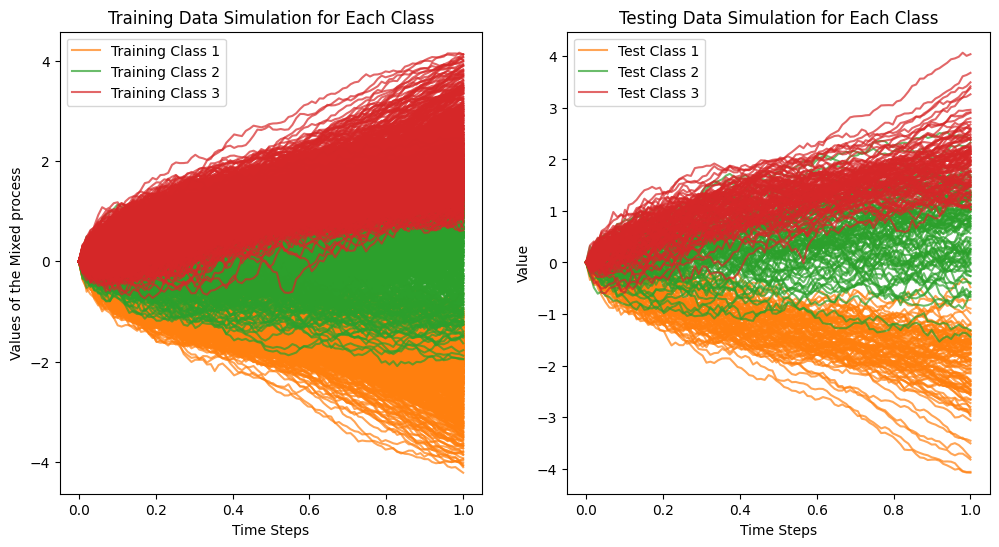

In [ ]:
t0 = 0;T = 1;x0 = 0;n = 100
Ni_train_list = np.array([1000,1000,1000])
Ni_test_list = np.array([100,100,100])
labels = np.array([1,2,3])
theta = np.array([-4,1,4])

# Prediction
Xtrain, ytrain, Xtest, ytest = simulation_sde(t0, T, x0, n, Ni_train_list,
                                              Ni_test_list, labels,
                                              b,sigma, theta)

### III. Predictions

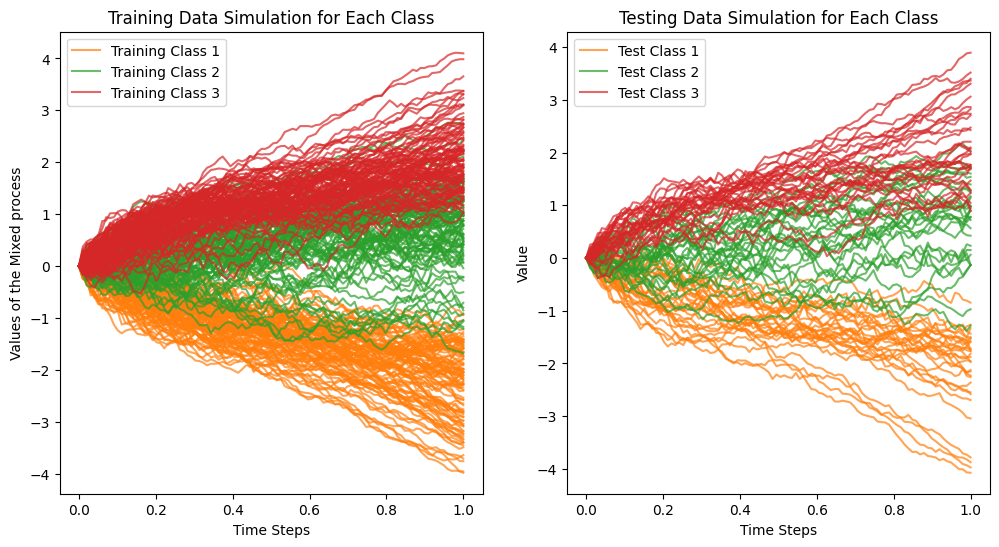


-----Begining Drift estimation-----


Drift Loop:   0%|          | 0/3 [00:00<?, ?it/s]


-----Class number 1 -----
K value in bfun : 1



Loop over observations:  26%|██▌       | 26/100 [00:00<00:00, 239.34it/s]

Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: 


Loop over observations:  77%|███████▋  | 77/100 [00:00<00:00, 391.94it/s]

 (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id

Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 392.35it/s]


Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 4)
K value in bfun : 2



Loop over observations:   0%|          | 0/100 [00:00<?, ?it/s]

Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: 


Loop over observations:  32%|███▏      | 32/100 [00:00<00:00, 277.88it/s]

Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: 


Loop over observations:  75%|███████▌  | 75/100 [00:00<00:00, 358.67it/s]

Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: 

Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 351.79it/s]


Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 5)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: 


Loop over observations:   0%|          | 0/100 [00:00<?, ?it/s]

Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: 


Loop over observations:  47%|████▋     | 47/100 [00:00<00:00, 357.79it/s]

 (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id


Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 394.59it/s]


Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 7)
Dimension of id_matrix: (99, 99)
Dimension of v_basis:

K value in bfun : 8



Loop over observations:   0%|          | 0/100 [00:00<?, ?it/s]

Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimensi


Loop over observations:  52%|█████▏    | 52/100 [00:00<00:00, 517.61it/s]

Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimensi

Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 428.69it/s]


 (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 11)
K value in bfun : 16



Loop over observations:   0%|          | 0/100 [00:00<?, ?it/s]

Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimensi


Loop over observations:  60%|██████    | 60/100 [00:00<00:00, 555.36it/s]

Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimensi

Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 427.75it/s]


Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 19)
K value in bfun : 32



Loop over observations:   0%|          | 0/100 [00:00<?, ?it/s]

Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimensi


Loop over observations:  32%|███▏      | 32/100 [00:00<00:00, 300.57it/s]

Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimensi


Loop over observations:  63%|██████▎   | 63/100 [00:00<00:00, 276.13it/s]

Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimensi


Loop over observations:  91%|█████████ | 91/100 [00:00<00:00, 219.36it/s]

Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)


Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 226.14it/s]

Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)
Dimension of id_matrix: (99, 99)
Dimension of v_basis: (99, 35)



Drift Loop:   0%|          | 0/3 [00:02<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/content/Ridge_result.feather'

In [ ]:
# Prediction
t0 = 0;T = 1;x0 = 0;n = 100
Ni_train_list = np.array([100,100,100])
Ni_test_list = np.array([30,30,30])
labels = np.array([1,2,3])
theta = np.array([-4,1,4])

# Prediction
Xtrain, ytrain, Xtest, ytest = simulation_sde(t0, T, x0, n, Ni_train_list,
                                              Ni_test_list, labels,
                                              b,sigma, theta)
SetK = 2 ** np.arange(6)
#SetK = 2 ** np.arange(2)
predicted_labels, predicted_labels_train = sde_classif(Xtrain, ytrain, Xtest,
                                                       ytest, SetK, labels, M = 3,
                                                       overfit_check = True)

### IV. Misclassification Analysis

#### Accuracy

In [ ]:
def accuracy (y_real, predictions) :
    return np.mean([y == pred for y,pred in zip(y_real,predictions)])

In [ ]:
print('Accuracy of the estimated classifier : ',accuracy(ytest, predicted_labels)*100,'%')
print('Misclassification ratio of the estimated classifier : ',(1-accuracy(ytest, predicted_labels))*100,'%')

Accuracy of the estimated classifier :  87.77777777777777 %
Misclassification ratio of the estimated classifier :  12.222222222222223 %


#### Accuracy wrt N

Here, we'll use n = 100, and N = 100,200,400,1000.

In [ ]:
accuracy_list_train = []
accuracy_list_test = []
N_list = [100,200,400,1000]

for N in tqdm(N_list, desc = 'N Loop'):
    print('\n-----Value of N : ',N,'-----')
    Ni_train_list = np.array([N,N,N])
    Xtrain, ytrain, Xtest, ytest = simulation_sde(t0, T, x0, n, Ni_train_list,
                                              Ni_test_list, labels,
                                              b,sigma, theta, plot=False)

    predicted_labels, predicted_labels_train = sde_classif(Xtrain, ytrain, Xtest, ytest, SetK, labels, M = 3, plot = False, overfit_check = True)
    accuracy_list_test.append(1-accuracy(ytest, predicted_labels))
    accuracy_list_train.append(1-accuracy(ytrain, predicted_labels_train))

N Loop:   0%|          | 0/4 [00:00<?, ?it/s]


-----Value of N :  100 -----

-----Begining Drift estimation-----



Drift Loop:   0%|          | 0/3 [00:00<?, ?it/s]


-----Class number 1 -----
K value in bfun : 1




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1957.55it/s]


K value in bfun : 2




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1926.09it/s]


K value in bfun : 4




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1986.42it/s]


K value in bfun : 8




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 2346.71it/s]


K value in bfun : 16




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 2210.55it/s]


K value in bfun : 32




Loop over observations:   0%|          | 0/100 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 919.66it/s]



-----Selected value K :  16 -----
K value in bfun : 16




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 2087.07it/s]

Drift Loop:  33%|███▎      | 1/3 [00:08<00:16,  8.29s/it]


-----Class number 2 -----
K value in bfun : 1




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 3529.01it/s]


K value in bfun : 2




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 3701.85it/s]


K value in bfun : 4




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 3804.39it/s]


K value in bfun : 8




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 2982.81it/s]


K value in bfun : 16




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 2802.16it/s]


K value in bfun : 32




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1801.31it/s]



-----Selected value K :  2 -----
K value in bfun : 2




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 2476.80it/s]

Drift Loop:  67%|██████▋   | 2/3 [00:16<00:08,  8.30s/it]


-----Class number 3 -----
K value in bfun : 1




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 3746.82it/s]


K value in bfun : 2




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 2149.02it/s]


K value in bfun : 4




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 2782.77it/s]


K value in bfun : 8




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 2276.72it/s]


K value in bfun : 16




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 3043.56it/s]


K value in bfun : 32




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1843.74it/s]



-----Selected value K :  32 -----
K value in bfun : 32




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 2201.08it/s]

Drift Loop: 100%|██████████| 3/3 [00:24<00:00,  8.11s/it]



-----Begining Diffusion estimation-----
K value in bfun : 1



Loop over observations: 100%|██████████| 300/300 [00:00<00:00, 3560.56it/s]


K value in bfun : 2



Loop over observations: 100%|██████████| 300/300 [00:00<00:00, 3950.65it/s]


K value in bfun : 4



Loop over observations: 100%|██████████| 300/300 [00:00<00:00, 3405.12it/s]


K value in bfun : 8



Loop over observations: 100%|██████████| 300/300 [00:00<00:00, 1631.27it/s]


K value in bfun : 16



Loop over observations: 100%|██████████| 300/300 [00:00<00:00, 1891.75it/s]


K value in bfun : 32



Loop over observations: 100%|██████████| 300/300 [00:00<00:00, 909.20it/s]



-----Selected value K :  4 -----
K value in bfun : 4



Loop over observations: 100%|██████████| 300/300 [00:00<00:00, 2497.45it/s]



-----Computation of probabilities-----



Probabilities Loop: 100%|██████████| 90/90 [00:00<00:00, 166.95it/s]



-----Prediction of labels-----



N Loop:  25%|██▌       | 1/4 [00:37<01:52, 37.61s/it]


-----Prediction of labels-----

-----Value of N :  200 -----

-----Begining Drift estimation-----



Drift Loop:   0%|          | 0/3 [00:00<?, ?it/s]


-----Class number 1 -----
K value in bfun : 1




Loop over observations:   0%|          | 0/200 [00:00<?, ?it/s]

Loop over observations:  40%|████      | 80/200 [00:00<00:00, 796.54it/s]

Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 514.18it/s]


K value in bfun : 2




Loop over observations:   0%|          | 0/200 [00:00<?, ?it/s]

Loop over observations:  24%|██▍       | 49/200 [00:00<00:00, 443.09it/s]

Loop over observations:  56%|█████▋    | 113/200 [00:00<00:00, 545.28it/s]

Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 602.86it/s]


K value in bfun : 4




Loop over observations:   0%|          | 0/200 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 1303.99it/s]


K value in bfun : 8




Loop over observations:   0%|          | 0/200 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 1372.69it/s]


K value in bfun : 16




Loop over observations:   0%|          | 0/200 [00:00<?, ?it/s]

Loop over observations:  46%|████▌     | 91/200 [00:00<00:00, 849.02it/s]

Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 733.69it/s]


K value in bfun : 32




Loop over observations:   0%|          | 0/200 [00:00<?, ?it/s]

Loop over observations:  16%|█▋        | 33/200 [00:00<00:00, 325.35it/s]

Loop over observations:  37%|███▋      | 74/200 [00:00<00:00, 371.49it/s]

Loop over observations:  57%|█████▋    | 114/200 [00:00<00:00, 383.57it/s]

Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 364.81it/s]



-----Selected value K :  16 -----
K value in bfun : 16




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 2304.02it/s]

Drift Loop:  33%|███▎      | 1/3 [00:12<00:25, 12.82s/it]


-----Class number 2 -----
K value in bfun : 1




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 3492.12it/s]


K value in bfun : 2




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 3346.31it/s]


K value in bfun : 4




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 2552.25it/s]


K value in bfun : 8




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 2608.13it/s]


K value in bfun : 16




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 2853.15it/s]


K value in bfun : 32




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 1985.34it/s]



-----Selected value K :  8 -----
K value in bfun : 8




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 2386.58it/s]

Drift Loop:  67%|██████▋   | 2/3 [00:21<00:10, 10.59s/it]


-----Class number 3 -----
K value in bfun : 1




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 3307.38it/s]


K value in bfun : 2




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 3014.77it/s]


K value in bfun : 4




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 2377.41it/s]


K value in bfun : 8




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 3130.56it/s]


K value in bfun : 16




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 2634.53it/s]


K value in bfun : 32




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 2088.50it/s]



-----Selected value K :  8 -----
K value in bfun : 8




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 2400.83it/s]

Drift Loop: 100%|██████████| 3/3 [00:31<00:00, 10.42s/it]



-----Begining Diffusion estimation-----
K value in bfun : 1



Loop over observations: 100%|██████████| 600/600 [00:00<00:00, 3935.75it/s]


K value in bfun : 2



Loop over observations: 100%|██████████| 600/600 [00:00<00:00, 3339.01it/s]


K value in bfun : 4



Loop over observations: 100%|██████████| 600/600 [00:00<00:00, 3620.28it/s]


K value in bfun : 8



Loop over observations: 100%|██████████| 600/600 [00:00<00:00, 3680.74it/s]


K value in bfun : 16



Loop over observations: 100%|██████████| 600/600 [00:00<00:00, 2479.68it/s]


K value in bfun : 32



Loop over observations: 100%|██████████| 600/600 [00:00<00:00, 1719.48it/s]



-----Selected value K :  8 -----
K value in bfun : 8



Loop over observations: 100%|██████████| 600/600 [00:00<00:00, 2798.05it/s]



-----Computation of probabilities-----



Probabilities Loop: 100%|██████████| 90/90 [00:00<00:00, 228.02it/s]



-----Prediction of labels-----



N Loop:  50%|█████     | 2/4 [01:25<01:27, 43.78s/it]


-----Prediction of labels-----

-----Value of N :  400 -----

-----Begining Drift estimation-----



Drift Loop:   0%|          | 0/3 [00:00<?, ?it/s]


-----Class number 1 -----
K value in bfun : 1




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations:  37%|███▋      | 147/400 [00:00<00:00, 1466.55it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 1403.37it/s]


K value in bfun : 2




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 1833.72it/s]


K value in bfun : 4




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations:  42%|████▏     | 169/400 [00:00<00:00, 1683.70it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 1595.28it/s]


K value in bfun : 8




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations:  31%|███▏      | 125/400 [00:00<00:00, 1243.07it/s]

Loop over observations:  62%|██████▎   | 250/400 [00:00<00:00, 1116.14it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 1032.97it/s]


K value in bfun : 16




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations:  22%|██▏       | 89/400 [00:00<00:00, 889.62it/s]

Loop over observations:  44%|████▍     | 178/400 [00:00<00:00, 556.33it/s]

Loop over observations:  60%|██████    | 241/400 [00:00<00:00, 519.75it/s]

Loop over observations:  74%|███████▍  | 297/400 [00:00<00:00, 455.97it/s]

Loop over observations:  86%|████████▋ | 345/400 [00:00<00:00, 428.62it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 468.55it/s]


K value in bfun : 32




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations:   7%|▋         | 27/400 [00:00<00:01, 260.40it/s]

Loop over observations:  14%|█▎        | 54/400 [00:00<00:01, 218.72it/s]

Loop over observations:  19%|█▉        | 77/400 [00:00<00:01, 164.53it/s]

Loop over observations:  24%|██▍       | 95/400 [00:00<00:02, 148.93it/s]

Loop over observations:  28%|██▊       | 111/400 [00:00<00:01, 151.17it/s]

Loop over observations:  32%|███▏      | 127/400 [00:00<00:01, 141.30it/s]

Loop over observations:  36%|███▌      | 142/400 [00:00<00:01, 138.05it/s]

Loop over observations:  44%|████▍     | 175/400 [00:01<00:01, 183.62it/s]

Loop over observations:  56%|█████▋    | 225/400 [00:01<00:00, 269.24it/s]

Loop over observations:  64%|██████▎   | 254/400 [00:01<00:00, 261.42it/s]

Loop over observations:  85%|████████▌ | 340/400 [00:01<00:00, 402.57it/s]

Loop over observations: 100%|██████████| 400/400 [00:01<00:00, 258.02it/s]



-----Selected value K :  8 -----
K value in bfun : 8




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 2552.57it/s]

Drift Loop:  33%|███▎      | 1/3 [00:17<00:34, 17.24s/it]


-----Class number 2 -----
K value in bfun : 1




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 3371.51it/s]


K value in bfun : 2




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 3295.47it/s]


K value in bfun : 4




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 3259.95it/s]


K value in bfun : 8




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 3076.71it/s]


K value in bfun : 16




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 3031.65it/s]


K value in bfun : 32




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations:  32%|███▏      | 129/400 [00:00<00:00, 1285.28it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 1385.21it/s]



-----Selected value K :  4 -----
K value in bfun : 4




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 2354.21it/s]

Drift Loop:  67%|██████▋   | 2/3 [00:28<00:13, 13.49s/it]


-----Class number 3 -----
K value in bfun : 1




Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 4047.41it/s]


K value in bfun : 2




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 3142.80it/s]


K value in bfun : 4




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 3178.54it/s]


K value in bfun : 8




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 2891.70it/s]


K value in bfun : 16




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 3142.25it/s]


K value in bfun : 32




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations:  48%|████▊     | 191/400 [00:00<00:00, 1903.93it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 1345.71it/s]



-----Selected value K :  8 -----
K value in bfun : 8




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 2628.91it/s]

Drift Loop: 100%|██████████| 3/3 [00:39<00:00, 13.21s/it]



-----Begining Diffusion estimation-----
K value in bfun : 1



Loop over observations: 100%|██████████| 1200/1200 [00:00<00:00, 3147.22it/s]


K value in bfun : 2



Loop over observations: 100%|██████████| 1200/1200 [00:00<00:00, 3564.71it/s]


K value in bfun : 4



Loop over observations: 100%|██████████| 1200/1200 [00:00<00:00, 3449.88it/s]


K value in bfun : 8



Loop over observations: 100%|██████████| 1200/1200 [00:00<00:00, 2787.10it/s]


K value in bfun : 16



Loop over observations: 100%|██████████| 1200/1200 [00:00<00:00, 3263.84it/s]


K value in bfun : 32



Loop over observations: 100%|██████████| 1200/1200 [00:00<00:00, 1746.81it/s]



-----Selected value K :  8 -----
K value in bfun : 8



Loop over observations: 100%|██████████| 1200/1200 [00:00<00:00, 3230.57it/s]



-----Computation of probabilities-----



Probabilities Loop: 100%|██████████| 90/90 [00:00<00:00, 155.03it/s]



-----Prediction of labels-----



Probabilities Loop:  86%|████████▌ | 1026/1200 [00:04<00:00, 251.52it/s]<ipython-input-4-666aa5338cf8>:92: RuntimeWarning: overflow encountered in exp
  ExpFspline[j, k] = VectorProba[k] * np.exp(np.sum(result))
<ipython-input-4-666aa5338cf8>:94: RuntimeWarning: invalid value encountered in divide
  VectorPi[j, :] = ExpFspline[j, :] / np.sum(ExpFspline[j, :])

N Loop:  75%|███████▌  | 3/4 [02:30<00:53, 53.34s/it]


-----Prediction of labels-----

-----Value of N :  1000 -----

-----Begining Drift estimation-----



Drift Loop:   0%|          | 0/3 [00:00<?, ?it/s]


-----Class number 1 -----
K value in bfun : 1




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  36%|███▌      | 358/1000 [00:00<00:00, 3575.20it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 3111.07it/s]


K value in bfun : 2




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  32%|███▏      | 316/1000 [00:00<00:00, 3159.26it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 3536.24it/s]


K value in bfun : 4




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  40%|████      | 400/1000 [00:00<00:00, 3997.31it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 3684.36it/s]


K value in bfun : 8




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  36%|███▋      | 363/1000 [00:00<00:00, 3629.55it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 3446.66it/s]


K value in bfun : 16




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  26%|██▌       | 257/1000 [00:00<00:00, 2569.46it/s]

Loop over observations:  51%|█████▏    | 514/1000 [00:00<00:00, 2310.03it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 2650.74it/s]


K value in bfun : 32




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  20%|██        | 205/1000 [00:00<00:00, 2042.93it/s]

Loop over observations:  41%|████      | 410/1000 [00:00<00:00, 1879.52it/s]

Loop over observations:  60%|█████▉    | 599/1000 [00:00<00:00, 1859.67it/s]

Loop over observations:  80%|████████  | 800/1000 [00:00<00:00, 1916.78it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 1888.88it/s]



-----Selected value K :  16 -----
K value in bfun : 16




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  25%|██▍       | 249/1000 [00:00<00:00, 2485.40it/s]

Loop over observations:  55%|█████▌    | 553/1000 [00:00<00:00, 2809.28it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 2971.87it/s]

Drift Loop:  33%|███▎      | 1/3 [00:15<00:31, 15.97s/it]


-----Class number 2 -----
K value in bfun : 1




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  38%|███▊      | 380/1000 [00:00<00:00, 3798.74it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 3441.36it/s]


K value in bfun : 2




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  34%|███▍      | 342/1000 [00:00<00:00, 3412.96it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 3428.06it/s]


K value in bfun : 4




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  36%|███▌      | 360/1000 [00:00<00:00, 3592.34it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 3583.90it/s]


K value in bfun : 8




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  35%|███▌      | 352/1000 [00:00<00:00, 3516.26it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 3567.79it/s]


K value in bfun : 16




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  29%|██▉       | 288/1000 [00:00<00:00, 2872.00it/s]

Loop over observations:  58%|█████▊    | 576/1000 [00:00<00:00, 2592.50it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 2843.60it/s]


K value in bfun : 32




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  18%|█▊        | 178/1000 [00:00<00:00, 1776.77it/s]

Loop over observations:  37%|███▋      | 369/1000 [00:00<00:00, 1853.96it/s]

Loop over observations:  56%|█████▌    | 555/1000 [00:00<00:00, 1843.16it/s]

Loop over observations:  75%|███████▌  | 753/1000 [00:00<00:00, 1896.74it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 1840.44it/s]



-----Selected value K :  4 -----
K value in bfun : 4




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  23%|██▎       | 230/1000 [00:00<00:00, 2293.45it/s]

Loop over observations:  56%|█████▌    | 560/1000 [00:00<00:00, 2883.78it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 2984.55it/s]

Drift Loop:  67%|██████▋   | 2/3 [00:31<00:15, 15.63s/it]


-----Class number 3 -----
K value in bfun : 1




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  38%|███▊      | 379/1000 [00:00<00:00, 3784.66it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 3397.14it/s]


K value in bfun : 2




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  35%|███▍      | 347/1000 [00:00<00:00, 3466.48it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 3568.04it/s]


K value in bfun : 4




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  31%|███▏      | 314/1000 [00:00<00:00, 3137.90it/s]

Loop over observations:  63%|██████▎   | 628/1000 [00:00<00:00, 2865.10it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 2372.33it/s]


K value in bfun : 8




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  20%|█▉        | 196/1000 [00:00<00:00, 1959.73it/s]

Loop over observations:  43%|████▎     | 429/1000 [00:00<00:00, 2173.50it/s]

Loop over observations:  66%|██████▋   | 663/1000 [00:00<00:00, 2248.33it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 2183.97it/s]


K value in bfun : 16




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  17%|█▋        | 170/1000 [00:00<00:00, 1696.62it/s]

Loop over observations:  34%|███▍      | 340/1000 [00:00<00:00, 1687.49it/s]

Loop over observations:  53%|█████▎    | 534/1000 [00:00<00:00, 1801.96it/s]

Loop over observations:  72%|███████▏  | 721/1000 [00:00<00:00, 1828.37it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 1795.29it/s]


K value in bfun : 32




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  12%|█▏        | 115/1000 [00:00<00:00, 1141.19it/s]

Loop over observations:  23%|██▎       | 230/1000 [00:00<00:00, 1126.33it/s]

Loop over observations:  34%|███▍      | 343/1000 [00:00<00:00, 1104.30it/s]

Loop over observations:  45%|████▌     | 454/1000 [00:00<00:00, 968.56it/s] 

Loop over observations:  55%|█████▌    | 553/1000 [00:00<00:00, 937.97it/s]

Loop over observations:  65%|██████▍   | 649/1000 [00:00<00:00, 851.30it/s]

Loop over observations:  74%|███████▎  | 736/1000 [00:00<00:00, 827.06it/s]

Loop over observations:  82%|████████▏ | 820/1000 [00:00<00:00, 758.02it/s]

Loop over observations:  90%|████████▉ | 899/1000 [00:01<00:00, 762.55it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:01<00:00, 848.43it/s]



-----Selected value K :  16 -----
K value in bfun : 16




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  12%|█▏        | 119/1000 [00:00<00:00, 1186.84it/s]

Loop over observations:  24%|██▍       | 238/1000 [00:00<00:01, 561.92it/s] 

Loop over observations:  32%|███▏      | 317/1000 [00:00<00:01, 597.09it/s]

Loop over observations:  39%|███▉      | 393/1000 [00:00<00:00, 642.45it/s]

Loop over observations:  58%|█████▊    | 580/1000 [00:00<00:00, 991.15it/s]

Loop over observations:  73%|███████▎  | 727/1000 [00:00<00:00, 1128.46it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 1049.24it/s]

Drift Loop: 100%|██████████| 3/3 [00:50<00:00, 16.69s/it]



-----Begining Diffusion estimation-----
K value in bfun : 1



Loop over observations: 100%|██████████| 3000/3000 [00:00<00:00, 3452.15it/s]


K value in bfun : 2



Loop over observations: 100%|██████████| 3000/3000 [00:00<00:00, 3359.57it/s]


K value in bfun : 4



Loop over observations: 100%|██████████| 3000/3000 [00:00<00:00, 3338.76it/s]


K value in bfun : 8



Loop over observations: 100%|██████████| 3000/3000 [00:00<00:00, 3246.66it/s]


K value in bfun : 16



Loop over observations: 100%|██████████| 3000/3000 [00:00<00:00, 3051.37it/s]


K value in bfun : 32



Loop over observations: 100%|██████████| 3000/3000 [00:01<00:00, 1733.92it/s]



-----Selected value K :  8 -----
K value in bfun : 8



Loop over observations: 100%|██████████| 3000/3000 [00:00<00:00, 3487.44it/s]



-----Computation of probabilities-----



Probabilities Loop: 100%|██████████| 90/90 [00:00<00:00, 269.12it/s]



-----Prediction of labels-----



N Loop: 100%|██████████| 4/4 [04:04<00:00, 61.06s/it]


-----Prediction of labels-----


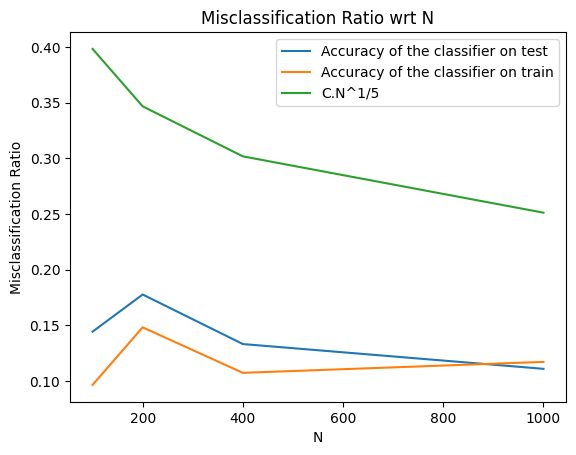

In [ ]:
plt.plot(N_list,accuracy_list_test, label='Accuracy of the classifier on test')
plt.plot(N_list,accuracy_list_train, label='Accuracy of the classifier on train')
plt.plot(N_list,[k**(-1/5) for k in N_list], label='C.N^1/5')
plt.xlabel('N')
plt.ylabel('Misclassification Ratio')
plt.title('Misclassification Ratio wrt N')
plt.legend()
plt.show()

## Generalization to Non-Homogenous Model

>The only thing we need to modify is the estimators of the drift and diffusion coefficients.

>Hence, we just need to modify the construction of the B-Spline basis (now depending on both space and time).

>First, we need to get the form of the estimator, using ridge regression, this time taking time into account.

>We are going to use a tensor product B-Spline : B(x,y) = B(x)B(y).

>Therefore, adapting the sphere of approximation, we'll get estimators of this form : $b_{i}(x, t) = \sum_{k=1}^{N_i} \sum_{j=1}^{N_i} \hat{a}_{k,j} B_k(x) B_j(t)$

>Let's introduce $B = (B_{j}(X_{i},t_{i}))_{i,j}$, with $1\leq i\leq n$, and $1\leq j \leq (K+M)^{2}$(I construct two B-Spline basis, one for space, other one for time, with same degree and num_basis, and then construct the B_Spline for the 2D case, by taking each pair of these 2 basis).

>The idea here is to explore just the part of space occupied by the Data : As an example, in the next plot giving the predictions of the estimated classifier, we don't need to evaluate the B-Spline functions on every couple $(X_{i},t_{j})$, but only when $i=j$, because when $i\neq j$, these are points that are not available in our data, and as N goes to infinity, these points become negligeable (Indeed, when we simulate an infinitely many time the same variable X, we get a set of point that is equal to Im(X) with probability 1).

>Then using the same property concerning Ridge regression, we'll get a solution of the form :

### --Time-- Modified Useful functions

In [ ]:
                          ###########################
def bfun_time(
    Mx : np.ndarray,
    times : np.ndarray,
    Inf_bound : float,
    Sup_bound : float,
    K : int,
    M: int
    )-> np.ndarray:
################################################################################
################################################################################
#### Creates the B-Spline matrix B = (B^j(X_i))_{i,j} in R^{N.n,K+M}
####
#### Mx : Matrix of observed trajectories
#### Inf_bound : Lower bound
#### Sup_bound : Higher bound
#### K : Number of non zero knots
#### M : Such that K+M = desired number of B-Spline functions
################################################################################
################################################################################
    print("K value in bfun :",K)
    #df_X = Mx
    N = Mx.shape[1]
    n = Mx.shape[0]
    matrix_B_time = bspline(times, 0, 1, K, M)
    matrix_B = np.zeros((N*n,K+M))
    for i in tqdm(range(N),desc='Loop over observations'):
            matrix_B[i*n:(i+1)*n,:] = bspline(Mx[:,i], Inf_bound, Sup_bound, K, M) * matrix_B_time
    return matrix_B

                          ###########################
def selectdimdrift_time(
    X : np.ndarray,
    times : np.ndarray,
    iZ : np.ndarray,
    c : float,
    SetKspline : np.ndarray,
    M : int,
    Inf_bound : float,
    Sup_bound : float,
    delta : float,
    Lconst : float
    )-> int:
################################################################################
################################################################################
#### Returns the value of K that minimizes the penalized criterion
####
#### X : Matrix of observed trajectories
#### iZ : matrix of successive differences
#### c : Coefficient of the penalization
#### SetKspline : Possible values for dimension K
#### M : Such that K+M = desired number of B-Spline functions
#### Inf_bound : Lower bound of the interval considered
#### Sup_bound : Upper bound of the interval considered
#### delta : TimeStep of discretization
#### Lconst : Constant defining the Upper Bound of Approximation
################################################################################
################################################################################
    N = X.shape[1]
    n = X.shape[0]
    Z = iZ
    B_ls = [bfun_time(X, times, Inf_bound, Sup_bound, k, M) for k in SetKspline]
    a_ls = [optimfun(B, Z, k, M, Lconst) for B, k in zip(B_ls, SetKspline)]
    gpen_vec = [gamma_pen(a, c, k, M, Z, B, n, N) for a, B, k in zip(a_ls, B_ls, SetKspline)]
    i_min = np.argmin(gpen_vec)
    K_ch = SetKspline[i_min]
    return K_ch

                          ###########################

def driftspline_time(
    x : np.ndarray,
    times : np.ndarray,
    a_hat : np.ndarray,
    Inf_bound : float,
    Sup_bound : float,
    K : int,
    M : int,
    Lconst : float):
################################################################################
################################################################################
#### Computes the Drift estimator
####
#### x : Observed trajectory
#### a_hat : Previously computed coefficients of the B-Spline Basis
#### Inf_bound : Lower bound of the interval considered
#### Sup_bound : Upper bound of the interval considered
#### K : Number of non-zero knots
#### M : Such that K+M = desired number of B-Spline functions
#### Lconst : Constant defining the Upper Bound of Approximation
################################################################################
################################################################################
    lab = labfun(x, Inf_bound, Sup_bound)
    idmat = np.diag(lab)
    B_space = bspline(x, Inf_bound, Sup_bound, K, M)
    B_time = bspline(times, 0, 1, K, M)
    B = B_space * B_time
    if len(idmat) != 0:
        Bs = idmat @ B
        b_hat = Bs @ a_hat
    else:
        b_hat = np.zeros_like(a_hat)
    b_hat = estimbound(b_hat, Lconst)
    return b_hat

                          ###########################

def selectdimdiff_time(
    X : np.ndarray,
    times : np.ndarray,
    U_ : np.ndarray,
    c : float,
    SetKspline : np.ndarray,
    M : int,
    Inf_bound : float,
    Sup_bound : float,
    delta : float,
    L_N : float
    )-> int:
################################################################################
################################################################################
#### Returns the value of K that minimizes the penalized criterion
####
#### X : Matrix of observed trajectories
#### iZ : matrix of successive differences
#### c : Coefficient of the penalization
#### SetKspline : Possible values for dimension K
#### M : Such that K+M = desired number of B-Spline functions
#### Inf_bound : Lower bound of the interval considered
#### Sup_bound : Upper bound of the interval considered
#### delta : TimeStep of discretization
#### Lconst : Constant defining the Upper Bound of Approximation
################################################################################
################################################################################
    N = X.shape[1]
    n = X.shape[0]
    U = U_
    B_ls = [bfun_time(X, times, Inf_bound, Sup_bound, k, M) for k in SetKspline]
    a_ls = [optimfun(B, U, k, M, L_N) for B, k in zip(B_ls, SetKspline)]
    gpen_vec = [gamma_pen2(a, c, k, M, U, B, n, N) for a, B, k in zip(a_ls, B_ls, SetKspline)]
    i_min = np.argmin(gpen_vec)
    K_ch = SetKspline[i_min]
    return K_ch

                          ###########################

def diffspline_time(
    x : np.ndarray,
    times : np.ndarray,
    a_hat : np.ndarray,
    Inf_bound : float,
    Sup_bound : float,
    K : int,
    M : int,
    L_N : float):
################################################################################
################################################################################
#### Computes the Diff estimator
####
#### x : Observed trajectory
#### a_hat : Previously computed coefficients of the B-Spline Basis
#### Inf_bound : Lower bound of the interval considered
#### Sup_bound : Upper bound of the interval considered
#### K : Number of non-zero knots
#### M : Such that K+M = desired number of B-Spline functions
#### Lconst : Constant defining the Upper Bound of Approximation
################################################################################
################################################################################
    lab = labfun(x, Inf_bound, Sup_bound)
    idmat = np.diag(lab)
    B_space = bspline(x, Inf_bound, Sup_bound, K, M)
    B_time = bspline(times, 0, 1, K, M)
    B = B_space * B_time
    if len(idmat) != 0:
        bsMat = idmat @ B
    else:
        B = np.zeros_like(B)
    sigma_hat = B @ a_hat
    result = zerofun(sigma_hat)
    result = estimbound(result, L_N)
    return result

                          ###########################

### --Time-- I. Main SDE Classification Function

In [ ]:
def sde_classif_time(Xtrain, ytrain, Xtest, ytest, SetK, labels, M = 3, plot=True, overfit_check=False):
    # Estimation of drift functions
    NbClass = len(labels)
    Drift_a_hat = [] #List of estimated coefficients for the drift per class
    Kdrift = np.zeros(NbClass, dtype = int) #List for selected value of dimension K per class
    N = Xtrain.shape[1] #Number of observed trajectories
    n = Xtrain.shape[0] #Number of observations per trajectory
    TimeStep = 1 / n #Time stamp
    L = np.log(N) #Bound corresponding in the paper to ANi.log(Ni)
    classified_data_list = [] #List of iXtrain so that we don't need to compute them again
    print('\n-----Begining Drift estimation-----')
    times = np.linspace(0, 1, n)
    for i in tqdm(range(NbClass), desc="Drift Loop"):
        print('\n-----Class number',i+1,'-----')
        iXtrain = Xtrain[:, ytrain == labels[i]]
        classified_data_list.append(iXtrain)
        N_i = iXtrain.shape[1]
        # print('N_i : ',N_i,'\n')
        # print('n : ',n)
        # SetK_i = [ k*int(( N_i*np.log(N_i) )**(1/5)) for k in SetK ]
        SupInt = np.log(N_i)
        InfInt = -SupInt
        iZ = zfun(iXtrain, TimeStep)
        Kdrift[i] = selectdimdrift_time(iXtrain[:n-1,:], times[:n-1], iZ, 0.1, SetK, M, InfInt, SupInt, TimeStep, L)
        #Kdrift[i - 1] = selectdimdrift(iXtrain[:-1,:], iZ, 0.1, SetK_i, M, InfInt, SupInt, TimeStep, L)
        # Kdrift[i - 1] = 5
        print('\n-----Selected value K : ',Kdrift[i],'-----' )
        #iB = bfun(iXtrain, InfInt, SupInt, int(Kdrift[i - 1]), M)
        iB = bfun_time(iXtrain[:n-1,:], times[:n-1], InfInt, SupInt, Kdrift[i], M)
        Drift_a_hat.append(optimfun(iB, iZ, Kdrift[i], M, L))

    # Estimation of the diffusion coefficient
    print('\n-----Begining Diffusion estimation-----')
    U = ufun(Xtrain, TimeStep)
    SupInt_ = np.log(N)
    InfInt_ = -SupInt_
    Kdiff = selectdimdiff_time(Xtrain[:n-1,:], times[:n-1], U, 5, SetK, M, InfInt_, SupInt_, TimeStep, L)
    #Kdiff = selectdimdiff(Xtrain[:-1,:], U, 5, SetK_, M, InfInt_, SupInt_, TimeStep, L)
    # Kdiff = 5
    print('\n-----Selected value K : ',Kdiff,'-----' )
    #B = bfun(Xtrain, InfInt_, SupInt_, int(Kdiff), M)
    B = bfun_time(Xtrain[:n-1,:], times[:n-1], InfInt_, SupInt_, Kdiff, M)
    Diff_a_hat = optimfun(B, U, Kdiff, M, L)

    # Computation of probabilities
    print('\n-----Computation of probabilities-----')
    n = Xtest.shape[0]
    ExpFspline = np.zeros((Xtest.shape[1], NbClass))
    VectorPi = np.zeros((Xtest.shape[1], NbClass))
    VectorProba = np.array([len(ytrain[ytrain == labels[k]]) / len(ytrain) for k in range(NbClass)])
    for j in tqdm(range(Xtest.shape[1]), desc = 'Probabilities Loop'):
        for k in range(NbClass):
            kXtrain = classified_data_list[k]

            SupInt = np.log(kXtrain.shape[1])
            InfInt = -SupInt


            drift_estim = driftspline_time(Xtest[:n-1, j], times[:n-1], Drift_a_hat[k], InfInt, SupInt, Kdrift[k], M, L) #--------------------------
            diff_estim = diffspline_time(Xtest[:n-1, j], times[:n-1], Diff_a_hat, InfInt_, SupInt_, Kdiff, M, L) #--------------------------

            result = ((drift_estim / diff_estim) * np.diff(Xtest[:, j]) - (TimeStep / 2) * (drift_estim ** 2 / diff_estim)) #--------------------------
            #result = ((drift_estim / diff_estim) * np.diff(Xtest[:, j]) - (TimeStep / 2) * (drift_estim ** 2 / diff_estim))
            # Scaling to avoid overflow
            scale_factor = 100
            ExpFspline[j,k] = VectorProba[k] * np.exp(np.sum(result/scale_factor))

        VectorPi[j, :] = ExpFspline[j, :] / np.sum(ExpFspline[j, :])

    # Prediction of labels
    print('\n-----Prediction of labels-----')
    argmax_vector = np.argmax(VectorPi, axis=1)
    PredClass = [labels[k] for k in argmax_vector]

    if overfit_check:
        n = Xtrain.shape[0]
        ExpFspline = np.zeros((Xtrain.shape[1], NbClass))
        VectorPi = np.zeros((Xtrain.shape[1], NbClass))
        VectorProba = np.array([np.sum([ytrain == labels[k]]) / len(ytrain) for k in range(NbClass)])
        for j in tqdm(range(Xtrain.shape[1]), desc = 'Probabilities Loop'):
            for k in range(NbClass):
                kXtrain = classified_data_list[k]

                SupInt = np.log(kXtrain.shape[1])
                InfInt = -SupInt


                drift_estim = driftspline(Xtrain[:n-1, j], Drift_a_hat[k], InfInt, SupInt, Kdrift[k], M, L)
                diff_estim = diffspline(Xtrain[:n-1, j], Diff_a_hat, InfInt_, SupInt_, Kdiff, M, L)
                # drift_estim = driftspline(Xtrain[:n, j], Drift_a_hat[k - 1], InfInt, SupInt, Kdrift[k - 1], M, L)
                # diff_estim = diffspline(Xtrain[:n, j], Diff_a_hat, InfInt_, SupInt_, Kdiff, M, L)

                result = ((drift_estim / diff_estim) * np.diff(Xtrain[:, j]) - (TimeStep / 2) * (drift_estim ** 2 / diff_estim))
                #result = ((drift_estim / diff_estim) * np.diff(Xtest[:, j]) - (TimeStep / 2) * (drift_estim ** 2 / diff_estim))
                # Scaling to avoid overflow
                scale_factor = 100
                ExpFspline[j,k] = VectorProba[k] * np.exp(np.sum(result/scale_factor))

            VectorPi[j, :] = ExpFspline[j, :] / np.sum(ExpFspline[j, :])

        # Prediction of labels
        print('\n-----Prediction of labels-----')
        argmax_vector_train = np.argmax(VectorPi, axis=1)
        PredClass_train = [labels[k] for k in argmax_vector_train]

    # Plot
    if plot:
        print('\n-----Plot incoming-----')
        #U = construct_u_vector(InfInt, SupInt, int(Kdiff), M)
        time_grid = np.linspace(t0, T, n)

        plt.figure(figsize=(12, 6))

        plt.subplot(1,2,1)
        for i in range(NbClass):
            class_data = Xtest[:, ytest == labels[i]]
            color_i =  'C'+str(labels[i])
            plt.plot(time_grid, class_data[:, 0],
                     color = color_i , alpha=0.7,
                     label=f'Testing Class {labels[i]}')

            U = np.linspace(InfInt, SupInt, Kdrift[i] + 1)
            U = np.concatenate(([InfInt] * M, U, [SupInt] * M))
            time_knots = np.linspace(0, 1, Kdrift[i] + M)
            time_knots = np.concatenate(([0] * M, time_knots, [1] * M))
            for t,u in zip(time_knots,U):
                plt.axvline(t, color = color_i, linestyle='--')
                plt.axhline(u, color = color_i, linestyle='--')
            for j in range(1,class_data.shape[1]):
                plt.plot(time_grid, class_data[:, j],
                         color = color_i , alpha=0.7)

        plt.xlabel('Time Steps')
        plt.ylabel('Values of the Mixed process')
        plt.title('Test Data Simulation for Each Class')
        plt.legend()

        plt.subplot(1,2,2)
        for j in range(Xtest.shape[1]):
            plt.plot(time_grid, Xtest[:, j],
                     color = 'C'+str(PredClass[j]) , alpha=0.7)
        plt.xlabel('Time Steps')
        plt.ylabel('Value')
        plt.title('Predictions')
        plt.legend()

        plt.show()

        # plt.figure(figsize=(12, 6))
        # for i in range(Xtrain.shape[1]):
        #     plt.plot(Xtrain[:, i], color='C' + str(int(ytrain[i])), label=f'Training Data {ytrain[i]}' if i == 0 else "")
        #     plt.legend()
        # plt.title("Training Data")

        # plt.show()
        if overfit_check:
            time_grid = np.linspace(t0, T, n)

            plt.figure(figsize=(12, 6))

            plt.subplot(1,2,1)
            for i in range(NbClass):
                class_data = Xtrain[:, ytrain == labels[i]]
                color_i =  'C'+str(labels[i])
                plt.plot(time_grid, class_data[:, 0],
                        color = color_i , alpha=0.7,
                        label=f'Testing Class {labels[i]}')

                U = np.linspace(InfInt, SupInt, Kdrift[i] + 1)
                U = np.concatenate(([InfInt] * M, U, [SupInt] * M))
                time_knots = np.linspace(0, 1, Kdrift[i] + M)
                time_knots = np.concatenate(([0] * M, time_knots, [1] * M))
                for t,u in zip(time_knots,U):
                    plt.axvline(t, color = color_i, linestyle='--')
                    plt.axhline(u, color = color_i, linestyle='--')

                for j in range(1,class_data.shape[1]):
                    plt.plot(time_grid, class_data[:, j],
                            color = color_i , alpha=0.7)

            plt.xlabel('Time Steps')
            plt.ylabel('Values of the Mixed process')
            plt.title('Train Data Simulation for Each Class')
            plt.legend()

            plt.subplot(1,2,2)
            for j in range(Xtrain.shape[1]):
                plt.plot(time_grid, Xtrain[:, j],
                         color = 'C'+str(PredClass_train[j]) , alpha=0.7)
            plt.xlabel('Time Steps')
            plt.ylabel('Value')
            plt.title('Predictions')
            plt.legend()

            plt.show()

    if overfit_check:
        return PredClass, PredClass_train
    else:
        return PredClass

### --Time-- II. Simulation of Data

In [ ]:
b_time = lambda x,theta,t: t*theta*(1/4 + (3/4)*(np.cos(x)**2))
sigma_time = lambda x,t : t*(0.1 + 0.9/(np.sqrt(1+x**2)))

def sde_sim_time(t0, T, X0, n, Ni, b, sigma, theta):
    dt = (T - t0) / n
    x = np.zeros((n,Ni))
    x[0,:] = X0
    for j in range(1, n):
        x[j,:] = x[j-1,:] + b(x[j-1,:], theta, j*dt) * dt + sigma(x[j-1,:],j*dt)*np.random.normal(0, 1, Ni) * np.sqrt(dt)
    return x


def simulation_sde_time(
    t0 : float,
    T : float,
    x0 : float,
    n : int,
    Ni_train_list : np.ndarray,
    Ni_test_list : np.ndarray,
    labels : np.ndarray,
    b,
    sigma,
    theta : np.ndarray,
    plot = True
    ):

################################################################################
################################################################################
#### Given drift and diffusion coefficients, simulates from the corresponding
#### SDE
####
#### T, t0 : Starting and ending time points
#### x0 : Space starting point, i.e deterministic value of X0
#### n : Discretization stamp
#### Ni_train_list,labels_train : Arrays such that Ni_train_list[i] = corresponding Ni of the class label[i]
#### Ni_test_list,labels_test : Same
#### b,sigma : Respectively drift and diffusion coefficients
#### theta : Array such that theta[i] is the corresponding theta for class i
################################################################################
################################################################################

    TimeStep = 1 / n
    NbClass = len(labels)

    Xtrain = sde_sim_time(0, 1, x0, n, Ni_train_list[0], b, sigma, theta = theta[0])
    ytrain = np.ones(Ni_train_list[0])*labels[0]
    Xtest = sde_sim_time(0, 1, x0, n, Ni_test_list[0], b, sigma, theta = theta[0])
    ytest = np.ones(Ni_test_list[0])*labels[0]

    for i in range(1,NbClass):
          Xtrain = np.hstack((Xtrain,sde_sim_time(0, 1, x0, n, Ni_train_list[i], b, sigma, theta = theta[i])))
          ytrain = np.concatenate((ytrain,np.ones(Ni_train_list[i])*labels[i]))
          Xtest = np.hstack((Xtest,sde_sim_time(0, 1, x0, n, Ni_test_list[i], b, sigma, theta = theta[i])))
          ytest = np.concatenate((ytest,np.ones(Ni_test_list[i])*labels[i]))

    if plot:
        #time_grid = np.linspace(t0, T, n+1)
        time_grid = np.linspace(t0, T, n)

        plt.figure(figsize=(12, 6))

        plt.subplot(1,2,1)
        for i in range(NbClass):
            class_data = Xtrain[:, ytrain == labels[i]]
            color_i =  'C'+str(labels[i])
            plt.plot(time_grid, class_data[:, 0],
                     color = color_i , alpha=0.7,
                     label=f'Training Class {labels[i]}')
            for j in range(1,class_data.shape[1]):
                plt.plot(time_grid, class_data[:, j],
                         color = color_i , alpha=0.7)
        plt.xlabel('Time Steps')
        plt.ylabel('Values of the Mixed process')
        plt.title('Training Data Simulation for Each Class')
        plt.legend()

        plt.subplot(1,2,2)
        for i in range(NbClass):
            class_data = Xtest[:, ytest == labels[i]]
            color_i =  'C'+str(labels[i])
            plt.plot(time_grid, class_data[:, 0],
                     color = color_i , alpha=0.7,
                     label=f'Test Class {labels[i]}')
            for j in range(1,class_data.shape[1]):
                plt.plot(time_grid, class_data[:, j],
                         color = color_i , alpha=0.7)
        plt.xlabel('Time Steps')
        plt.ylabel('Value')
        plt.title('Testing Data Simulation for Each Class')
        plt.legend()

        plt.show()

    return Xtrain, ytrain, Xtest, ytest

### --Time-- III. Predictions

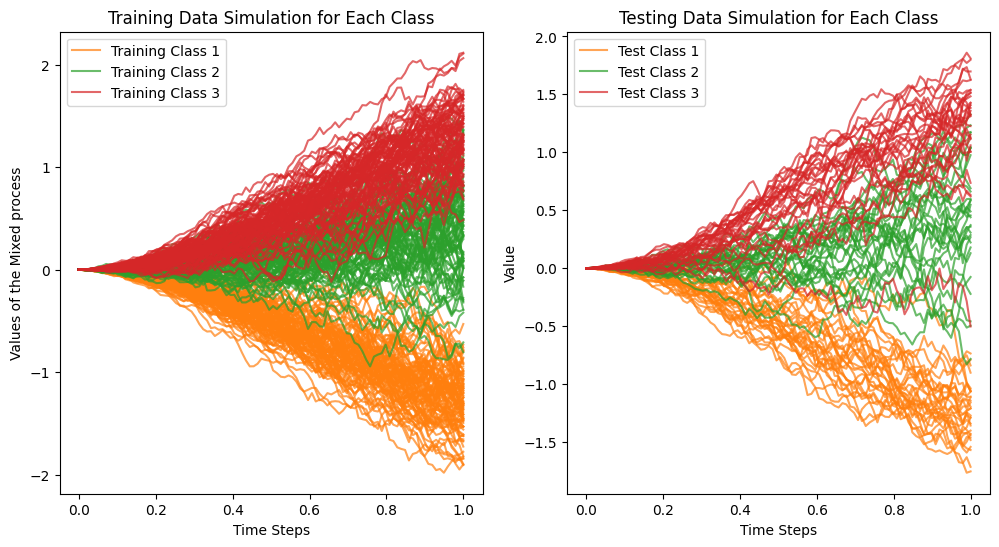


-----Begining Drift estimation-----


Drift Loop:   0%|          | 0/3 [00:00<?, ?it/s]


-----Class number 1 -----
K value in bfun : 1



Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1657.66it/s]


K value in bfun : 2



Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1376.49it/s]


K value in bfun : 4



Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1451.84it/s]


K value in bfun : 8



Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1590.58it/s]


K value in bfun : 16



Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1430.51it/s]


K value in bfun : 32



Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 504.11it/s]



-----Selected value K :  2 -----
K value in bfun : 2



Drift Loop:  33%|███▎      | 1/3 [00:11<00:22, 11.01s/it]


-----Class number 2 -----
K value in bfun : 1



Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1682.97it/s]


K value in bfun : 2



Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1676.13it/s]


K value in bfun : 4



Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1544.23it/s]


K value in bfun : 8



Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1650.35it/s]


K value in bfun : 16



Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1601.40it/s]


K value in bfun : 32



Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 702.94it/s]



-----Selected value K :  1 -----
K value in bfun : 1



Drift Loop:  67%|██████▋   | 2/3 [00:21<00:10, 10.57s/it]


-----Class number 3 -----
K value in bfun : 1



Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1672.05it/s]


K value in bfun : 2



Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1390.01it/s]


K value in bfun : 4



Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1670.56it/s]


K value in bfun : 8



Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1528.98it/s]


K value in bfun : 16



Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1338.57it/s]


K value in bfun : 32



Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 650.00it/s]



-----Selected value K :  2 -----
K value in bfun : 2



Drift Loop: 100%|██████████| 3/3 [00:31<00:00, 10.59s/it]



-----Begining Diffusion estimation-----
K value in bfun : 1


Loop over observations: 100%|██████████| 300/300 [00:00<00:00, 1298.80it/s]


K value in bfun : 2


Loop over observations: 100%|██████████| 300/300 [00:00<00:00, 1336.64it/s]


K value in bfun : 4


Loop over observations: 100%|██████████| 300/300 [00:00<00:00, 1956.09it/s]


K value in bfun : 8


Loop over observations: 100%|██████████| 300/300 [00:00<00:00, 2358.38it/s]


K value in bfun : 16


Loop over observations: 100%|██████████| 300/300 [00:00<00:00, 1803.15it/s]


K value in bfun : 32


Loop over observations: 100%|██████████| 300/300 [00:00<00:00, 1123.12it/s]



-----Selected value K :  1 -----
K value in bfun : 1


Loop over observations: 100%|██████████| 300/300 [00:00<00:00, 1965.20it/s]



-----Computation of probabilities-----


Probabilities Loop: 100%|██████████| 90/90 [00:01<00:00, 79.63it/s]



-----Prediction of labels-----


Probabilities Loop: 100%|██████████| 300/300 [00:01<00:00, 159.70it/s]



-----Prediction of labels-----

-----Plot incoming-----


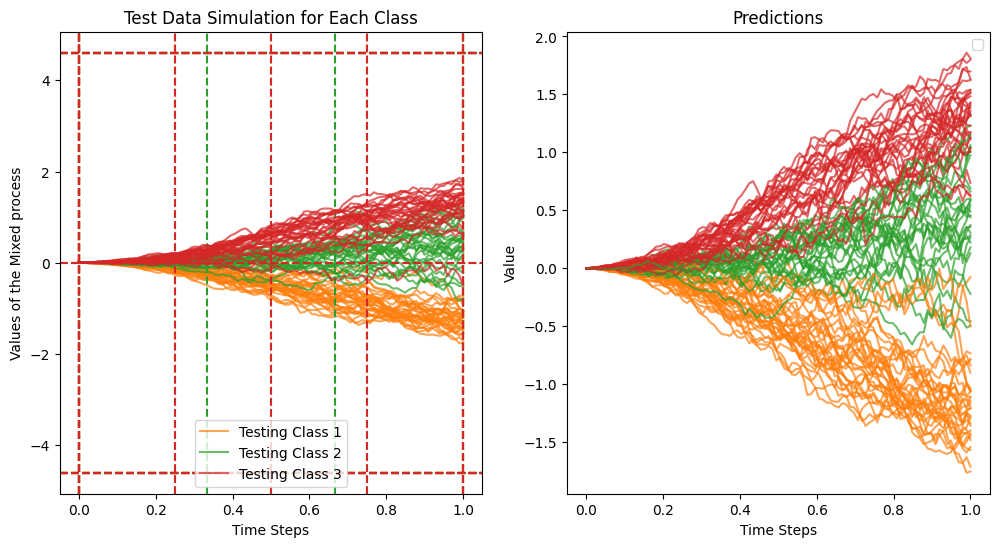

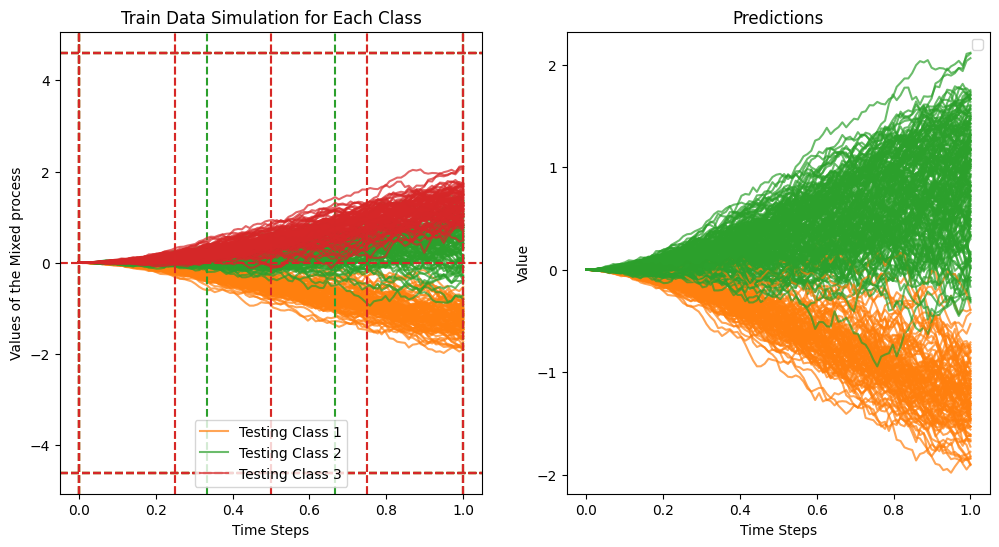

In [ ]:
# Prediction
t0 = 0;T = 1;x0 = 0;n = 100
Ni_train_list = np.array([100,100,100])
Ni_test_list = np.array([30,30,30])
labels = np.array([1,2,3])
theta = np.array([-4,1,4])

# Prediction
Xtrain, ytrain, Xtest, ytest = simulation_sde_time(t0, T, x0, n, Ni_train_list,
                                              Ni_test_list, labels,
                                              b_time,sigma_time, theta)
SetK = 2 ** np.arange(6)
#SetK = 2 ** np.arange(2)
predicted_labels, predicted_labels_train = sde_classif_time(Xtrain, ytrain, Xtest,
                                                       ytest, SetK, labels, M = 3,
                                                       overfit_check = True)

### --Time-- IV. Misclassification Analysis

In [ ]:
print('Accuracy of the estimated classifier : ',accuracy(ytest, predicted_labels)*100,'%')
print('Misclassification ratio of the estimated classifier : ',(1-accuracy(ytest, predicted_labels))*100,'%')

Accuracy of the estimated classifier :  90.0 %
Misclassification ratio of the estimated classifier :  9.999999999999998 %


##### Accuracy wrt N

Here, we'll use n = 100, and N = 100, 200, 400, 1000.

In [ ]:
accuracy_list_train = []
accuracy_list_test = []
N_list = [100,200,400,1000]

for N in tqdm(N_list, desc = 'N Loop'):
    print('\n-----Value of N : ',N,'-----')
    Ni_train_list = np.array([N,N,N])
    Xtrain, ytrain, Xtest, ytest = simulation_sde_time(t0, T, x0, n, Ni_train_list,
                                              Ni_test_list, labels,
                                              b_time,sigma_time, theta, plot=False)

    predicted_labels, predicted_labels_train = sde_classif_time(Xtrain, ytrain, Xtest, ytest, SetK, labels, M = 3, plot = False, overfit_check = True)
    accuracy_list_test.append(1-accuracy(ytest, predicted_labels))
    accuracy_list_train.append(1-accuracy(ytrain, predicted_labels_train))

N Loop:   0%|          | 0/4 [00:00<?, ?it/s]


-----Value of N :  100 -----

-----Begining Drift estimation-----



Drift Loop:   0%|          | 0/3 [00:00<?, ?it/s]


-----Class number 1 -----
K value in bfun : 1




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1825.42it/s]


K value in bfun : 2




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 2726.80it/s]


K value in bfun : 4




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 2048.67it/s]


K value in bfun : 8




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1923.34it/s]


K value in bfun : 16




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1760.43it/s]


K value in bfun : 32




Loop over observations:   0%|          | 0/100 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 641.47it/s]



-----Selected value K :  2 -----
K value in bfun : 2




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1654.24it/s]

Drift Loop:  33%|███▎      | 1/3 [00:10<00:21, 10.76s/it]


-----Class number 2 -----
K value in bfun : 1




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 2458.56it/s]


K value in bfun : 2




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 2392.11it/s]


K value in bfun : 4




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 2721.15it/s]


K value in bfun : 8




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 2611.27it/s]


K value in bfun : 16




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 2181.28it/s]


K value in bfun : 32




Loop over observations:   0%|          | 0/100 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 786.48it/s]



-----Selected value K :  1 -----
K value in bfun : 1




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1723.09it/s]

Drift Loop:  67%|██████▋   | 2/3 [00:20<00:10, 10.05s/it]


-----Class number 3 -----
K value in bfun : 1




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1325.64it/s]


K value in bfun : 2




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1288.39it/s]


K value in bfun : 4




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1451.77it/s]


K value in bfun : 8




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1492.67it/s]


K value in bfun : 16




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1377.66it/s]


K value in bfun : 32




Loop over observations:   0%|          | 0/100 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 569.52it/s]



-----Selected value K :  2 -----
K value in bfun : 2




Loop over observations: 100%|██████████| 100/100 [00:00<00:00, 1618.16it/s]

Drift Loop: 100%|██████████| 3/3 [00:30<00:00, 10.15s/it]



-----Begining Diffusion estimation-----
K value in bfun : 1



Loop over observations: 100%|██████████| 300/300 [00:00<00:00, 2472.28it/s]


K value in bfun : 2



Loop over observations: 100%|██████████| 300/300 [00:00<00:00, 2401.91it/s]


K value in bfun : 4



Loop over observations: 100%|██████████| 300/300 [00:00<00:00, 2112.99it/s]


K value in bfun : 8



Loop over observations: 100%|██████████| 300/300 [00:00<00:00, 2228.23it/s]


K value in bfun : 16



Loop over observations: 100%|██████████| 300/300 [00:00<00:00, 2256.19it/s]


K value in bfun : 32



Loop over observations: 100%|██████████| 300/300 [00:00<00:00, 853.16it/s]



-----Selected value K :  1 -----
K value in bfun : 1



Loop over observations: 100%|██████████| 300/300 [00:00<00:00, 1904.09it/s]



-----Computation of probabilities-----



Probabilities Loop: 100%|██████████| 90/90 [00:00<00:00, 141.45it/s]



-----Prediction of labels-----



N Loop:  25%|██▌       | 1/4 [00:44<02:12, 44.29s/it]


-----Prediction of labels-----

-----Value of N :  200 -----

-----Begining Drift estimation-----



Drift Loop:   0%|          | 0/3 [00:00<?, ?it/s]


-----Class number 1 -----
K value in bfun : 1




Loop over observations:   0%|          | 0/200 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 1827.97it/s]


K value in bfun : 2




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 2572.11it/s]


K value in bfun : 4




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 2383.33it/s]


K value in bfun : 8




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 2439.53it/s]


K value in bfun : 16




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 2476.71it/s]


K value in bfun : 32




Loop over observations:   0%|          | 0/200 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 1332.96it/s]



-----Selected value K :  2 -----
K value in bfun : 2




Loop over observations:   0%|          | 0/200 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 1576.06it/s]

Drift Loop:  33%|███▎      | 1/3 [00:11<00:22, 11.41s/it]


-----Class number 2 -----
K value in bfun : 1




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 2203.77it/s]


K value in bfun : 2




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 2840.46it/s]


K value in bfun : 4




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 2471.10it/s]


K value in bfun : 8




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 2232.71it/s]


K value in bfun : 16




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 2217.69it/s]


K value in bfun : 32




Loop over observations:   0%|          | 0/200 [00:00<?, ?it/s]

Loop over observations:  46%|████▋     | 93/200 [00:00<00:00, 926.76it/s]

Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 876.89it/s]



-----Selected value K :  1 -----
K value in bfun : 1




Loop over observations:   0%|          | 0/200 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 1601.92it/s]

Drift Loop:  67%|██████▋   | 2/3 [00:22<00:11, 11.33s/it]


-----Class number 3 -----
K value in bfun : 1




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 2524.04it/s]


K value in bfun : 2




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 2400.07it/s]


K value in bfun : 4




Loop over observations:   0%|          | 0/200 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 1671.84it/s]


K value in bfun : 8




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 2417.37it/s]


K value in bfun : 16




Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 2542.24it/s]


K value in bfun : 32




Loop over observations:   0%|          | 0/200 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 1230.91it/s]



-----Selected value K :  2 -----
K value in bfun : 2




Loop over observations:   0%|          | 0/200 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 200/200 [00:00<00:00, 1652.77it/s]

Drift Loop: 100%|██████████| 3/3 [00:34<00:00, 11.49s/it]



-----Begining Diffusion estimation-----
K value in bfun : 1



Loop over observations: 100%|██████████| 600/600 [00:00<00:00, 2578.61it/s]


K value in bfun : 2



Loop over observations: 100%|██████████| 600/600 [00:00<00:00, 2172.53it/s]


K value in bfun : 4



Loop over observations: 100%|██████████| 600/600 [00:00<00:00, 2490.69it/s]


K value in bfun : 8



Loop over observations: 100%|██████████| 600/600 [00:00<00:00, 2279.29it/s]


K value in bfun : 16



Loop over observations: 100%|██████████| 600/600 [00:00<00:00, 2217.10it/s]


K value in bfun : 32



Loop over observations: 100%|██████████| 600/600 [00:00<00:00, 925.89it/s] 



-----Selected value K :  1 -----
K value in bfun : 1



Loop over observations: 100%|██████████| 600/600 [00:00<00:00, 2083.13it/s]



-----Computation of probabilities-----



Probabilities Loop: 100%|██████████| 90/90 [00:00<00:00, 136.84it/s]



-----Prediction of labels-----



N Loop:  50%|█████     | 2/4 [01:37<01:39, 49.53s/it]


-----Prediction of labels-----

-----Value of N :  400 -----

-----Begining Drift estimation-----



Drift Loop:   0%|          | 0/3 [00:00<?, ?it/s]


-----Class number 1 -----
K value in bfun : 1




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 2680.04it/s]


K value in bfun : 2




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 2457.70it/s]


K value in bfun : 4




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 2414.58it/s]


K value in bfun : 8




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 2208.87it/s]


K value in bfun : 16




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations:  43%|████▎     | 173/400 [00:00<00:00, 1717.25it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 1596.44it/s]


K value in bfun : 32




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations:  32%|███▏      | 129/400 [00:00<00:00, 1285.24it/s]

Loop over observations:  64%|██████▍   | 258/400 [00:00<00:00, 1246.23it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 1143.50it/s]



-----Selected value K :  2 -----
K value in bfun : 2




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations:  34%|███▎      | 134/400 [00:00<00:00, 1337.51it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 1874.21it/s]

Drift Loop:  33%|███▎      | 1/3 [00:13<00:27, 13.51s/it]


-----Class number 2 -----
K value in bfun : 1




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 2419.06it/s]


K value in bfun : 2




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 2439.26it/s]


K value in bfun : 4




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 2368.13it/s]


K value in bfun : 8




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 2451.73it/s]


K value in bfun : 16




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 2376.18it/s]


K value in bfun : 32




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations:  24%|██▍       | 95/400 [00:00<00:00, 944.35it/s]

Loop over observations:  56%|█████▋    | 226/400 [00:00<00:00, 1156.36it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 892.71it/s]



-----Selected value K :  1 -----
K value in bfun : 1




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 2061.96it/s]

Drift Loop:  67%|██████▋   | 2/3 [00:26<00:13, 13.34s/it]


-----Class number 3 -----
K value in bfun : 1




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 2668.57it/s]


K value in bfun : 2




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 2331.01it/s]


K value in bfun : 4




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 2578.72it/s]


K value in bfun : 8




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 2413.81it/s]


K value in bfun : 16




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 2335.05it/s]


K value in bfun : 32




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations:  24%|██▍       | 95/400 [00:00<00:00, 932.16it/s]

Loop over observations:  47%|████▋     | 189/400 [00:00<00:00, 906.24it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 882.92it/s]



-----Selected value K :  2 -----
K value in bfun : 2




Loop over observations:   0%|          | 0/400 [00:00<?, ?it/s]

Loop over observations:  38%|███▊      | 150/400 [00:00<00:00, 1498.90it/s]

Loop over observations: 100%|██████████| 400/400 [00:00<00:00, 1892.06it/s]

Drift Loop: 100%|██████████| 3/3 [00:40<00:00, 13.58s/it]



-----Begining Diffusion estimation-----
K value in bfun : 1



Loop over observations: 100%|██████████| 1200/1200 [00:00<00:00, 2539.10it/s]


K value in bfun : 2



Loop over observations: 100%|██████████| 1200/1200 [00:00<00:00, 2246.05it/s]


K value in bfun : 4



Loop over observations: 100%|██████████| 1200/1200 [00:00<00:00, 2258.30it/s]


K value in bfun : 8



Loop over observations: 100%|██████████| 1200/1200 [00:00<00:00, 2085.80it/s]


K value in bfun : 16



Loop over observations: 100%|██████████| 1200/1200 [00:00<00:00, 1762.57it/s]


K value in bfun : 32



Loop over observations: 100%|██████████| 1200/1200 [00:02<00:00, 500.30it/s]



-----Selected value K :  1 -----
K value in bfun : 1



Loop over observations: 100%|██████████| 1200/1200 [00:00<00:00, 2313.92it/s]



-----Computation of probabilities-----



Probabilities Loop: 100%|██████████| 90/90 [00:00<00:00, 137.08it/s]



-----Prediction of labels-----



N Loop:  75%|███████▌  | 3/4 [02:52<01:01, 61.21s/it]


-----Prediction of labels-----

-----Value of N :  1000 -----

-----Begining Drift estimation-----



Drift Loop:   0%|          | 0/3 [00:00<?, ?it/s]


-----Class number 1 -----
K value in bfun : 1




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  16%|█▌        | 160/1000 [00:00<00:00, 1592.64it/s]

Loop over observations:  32%|███▏      | 320/1000 [00:00<00:00, 1531.04it/s]

Loop over observations:  48%|████▊     | 475/1000 [00:00<00:00, 1537.48it/s]

Loop over observations:  63%|██████▎   | 629/1000 [00:00<00:00, 1523.40it/s]

Loop over observations:  78%|███████▊  | 782/1000 [00:00<00:00, 1474.88it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 1472.53it/s]


K value in bfun : 2




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  14%|█▍        | 145/1000 [00:00<00:00, 1445.55it/s]

Loop over observations:  29%|██▉       | 290/1000 [00:00<00:00, 1413.19it/s]

Loop over observations:  44%|████▍     | 440/1000 [00:00<00:00, 1448.86it/s]

Loop over observations:  58%|█████▊    | 585/1000 [00:00<00:00, 1440.09it/s]

Loop over observations:  73%|███████▎  | 730/1000 [00:00<00:00, 1428.74it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 1521.20it/s]


K value in bfun : 4




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  24%|██▍       | 241/1000 [00:00<00:00, 2405.68it/s]

Loop over observations:  48%|████▊     | 482/1000 [00:00<00:00, 2119.99it/s]

Loop over observations:  70%|██████▉   | 697/1000 [00:00<00:00, 2028.12it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 2131.64it/s]


K value in bfun : 8




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  21%|██        | 206/1000 [00:00<00:00, 2055.91it/s]

Loop over observations:  45%|████▍     | 448/1000 [00:00<00:00, 2267.06it/s]

Loop over observations:  69%|██████▉   | 694/1000 [00:00<00:00, 2352.91it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 2317.16it/s]


K value in bfun : 16




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  25%|██▍       | 246/1000 [00:00<00:00, 2457.54it/s]

Loop over observations:  49%|████▉     | 492/1000 [00:00<00:00, 2390.99it/s]

Loop over observations:  73%|███████▎  | 732/1000 [00:00<00:00, 1980.66it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 2019.62it/s]


K value in bfun : 32




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  13%|█▎        | 127/1000 [00:00<00:00, 1268.46it/s]

Loop over observations:  25%|██▌       | 254/1000 [00:00<00:00, 1083.13it/s]

Loop over observations:  37%|███▋      | 372/1000 [00:00<00:00, 1122.86it/s]

Loop over observations:  49%|████▉     | 494/1000 [00:00<00:00, 1158.56it/s]

Loop over observations:  63%|██████▎   | 626/1000 [00:00<00:00, 1214.21it/s]

Loop over observations:  75%|███████▍  | 749/1000 [00:00<00:00, 1190.95it/s]

Loop over observations:  87%|████████▋ | 869/1000 [00:00<00:00, 1148.43it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 1107.42it/s]



-----Selected value K :  2 -----
K value in bfun : 2




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  17%|█▋        | 168/1000 [00:00<00:00, 1679.10it/s]

Loop over observations:  39%|███▉      | 393/1000 [00:00<00:00, 2010.75it/s]

Loop over observations:  62%|██████▏   | 620/1000 [00:00<00:00, 2128.34it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 2168.91it/s]

Drift Loop:  33%|███▎      | 1/3 [00:22<00:44, 22.35s/it]


-----Class number 2 -----
K value in bfun : 1




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  26%|██▋       | 265/1000 [00:00<00:00, 2642.56it/s]

Loop over observations:  53%|█████▎    | 530/1000 [00:00<00:00, 2359.13it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 2363.03it/s]


K value in bfun : 2




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  26%|██▌       | 258/1000 [00:00<00:00, 2579.59it/s]

Loop over observations:  52%|█████▏    | 516/1000 [00:00<00:00, 2565.34it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 2506.64it/s]


K value in bfun : 4




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  27%|██▋       | 269/1000 [00:00<00:00, 2687.20it/s]

Loop over observations:  54%|█████▍    | 538/1000 [00:00<00:00, 2609.84it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 2337.96it/s]


K value in bfun : 8




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  13%|█▎        | 129/1000 [00:00<00:00, 1286.12it/s]

Loop over observations:  36%|███▋      | 365/1000 [00:00<00:00, 1910.35it/s]

Loop over observations:  58%|█████▊    | 585/1000 [00:00<00:00, 2040.36it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 2090.27it/s]


K value in bfun : 16




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  24%|██▍       | 243/1000 [00:00<00:00, 2422.40it/s]

Loop over observations:  49%|████▊     | 486/1000 [00:00<00:00, 2408.13it/s]

Loop over observations:  73%|███████▎  | 727/1000 [00:00<00:00, 2392.10it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 2221.71it/s]


K value in bfun : 32




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  11%|█         | 111/1000 [00:00<00:00, 1109.73it/s]

Loop over observations:  22%|██▏       | 222/1000 [00:00<00:00, 910.35it/s] 

Loop over observations:  34%|███▍      | 343/1000 [00:00<00:00, 1030.24it/s]

Loop over observations:  48%|████▊     | 475/1000 [00:00<00:00, 1134.81it/s]

Loop over observations:  60%|██████    | 601/1000 [00:00<00:00, 1177.19it/s]

Loop over observations:  72%|███████▏  | 721/1000 [00:00<00:00, 912.92it/s] 

Loop over observations:  82%|████████▏ | 822/1000 [00:00<00:00, 779.51it/s]

Loop over observations:  91%|█████████ | 909/1000 [00:01<00:00, 664.37it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:01<00:00, 770.49it/s]



-----Selected value K :  1 -----
K value in bfun : 1




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:   9%|▊         | 87/1000 [00:00<00:01, 867.92it/s]

Loop over observations:  22%|██▏       | 215/1000 [00:00<00:00, 1106.77it/s]

Loop over observations:  34%|███▍      | 341/1000 [00:00<00:00, 1176.49it/s]

Loop over observations:  49%|████▉     | 491/1000 [00:00<00:00, 1301.51it/s]

Loop over observations:  64%|██████▍   | 638/1000 [00:00<00:00, 1360.63it/s]

Loop over observations:  78%|███████▊  | 775/1000 [00:00<00:00, 1359.97it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 1321.76it/s]

Drift Loop:  67%|██████▋   | 2/3 [00:43<00:21, 21.78s/it]


-----Class number 3 -----
K value in bfun : 1




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  26%|██▌       | 258/1000 [00:00<00:00, 2576.43it/s]

Loop over observations:  52%|█████▏    | 516/1000 [00:00<00:00, 2515.92it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 2557.51it/s]


K value in bfun : 2




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  26%|██▋       | 264/1000 [00:00<00:00, 2636.48it/s]

Loop over observations:  53%|█████▎    | 528/1000 [00:00<00:00, 2609.72it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 2497.05it/s]


K value in bfun : 4




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  16%|█▌        | 158/1000 [00:00<00:00, 1558.61it/s]

Loop over observations:  34%|███▍      | 341/1000 [00:00<00:00, 1716.14it/s]

Loop over observations:  59%|█████▊    | 586/1000 [00:00<00:00, 2048.78it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 2089.91it/s]


K value in bfun : 8




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  24%|██▍       | 244/1000 [00:00<00:00, 2433.41it/s]

Loop over observations:  50%|█████     | 501/1000 [00:00<00:00, 2509.12it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 2430.79it/s]


K value in bfun : 16




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  18%|█▊        | 178/1000 [00:00<00:00, 1776.00it/s]

Loop over observations:  36%|███▌      | 356/1000 [00:00<00:00, 1680.68it/s]

Loop over observations:  57%|█████▊    | 575/1000 [00:00<00:00, 1905.39it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 2001.42it/s]


K value in bfun : 32




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  12%|█▏        | 122/1000 [00:00<00:00, 1217.46it/s]

Loop over observations:  24%|██▍       | 244/1000 [00:00<00:00, 1204.42it/s]

Loop over observations:  37%|███▋      | 374/1000 [00:00<00:00, 1246.07it/s]

Loop over observations:  50%|█████     | 503/1000 [00:00<00:00, 1260.43it/s]

Loop over observations:  63%|██████▎   | 630/1000 [00:00<00:00, 1130.37it/s]

Loop over observations:  75%|███████▍  | 746/1000 [00:00<00:00, 987.83it/s] 

Loop over observations:  85%|████████▍ | 849/1000 [00:00<00:00, 991.40it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 1054.09it/s]



-----Selected value K :  2 -----
K value in bfun : 2




Loop over observations:   0%|          | 0/1000 [00:00<?, ?it/s]

Loop over observations:  14%|█▍        | 140/1000 [00:00<00:00, 1394.65it/s]

Loop over observations:  36%|███▌      | 358/1000 [00:00<00:00, 1853.50it/s]

Loop over observations:  62%|██████▏   | 621/1000 [00:00<00:00, 2205.92it/s]

Loop over observations: 100%|██████████| 1000/1000 [00:00<00:00, 2197.54it/s]

Drift Loop: 100%|██████████| 3/3 [01:06<00:00, 22.15s/it]



-----Begining Diffusion estimation-----
K value in bfun : 1



Loop over observations: 100%|██████████| 3000/3000 [00:01<00:00, 1777.99it/s]


K value in bfun : 2



Loop over observations: 100%|██████████| 3000/3000 [00:02<00:00, 1372.26it/s]


K value in bfun : 4



Loop over observations: 100%|██████████| 3000/3000 [00:01<00:00, 1740.53it/s]


K value in bfun : 8



Loop over observations: 100%|██████████| 3000/3000 [00:01<00:00, 2252.25it/s]


K value in bfun : 16



Loop over observations: 100%|██████████| 3000/3000 [00:01<00:00, 1999.26it/s]


K value in bfun : 32



Loop over observations: 100%|██████████| 3000/3000 [00:02<00:00, 1051.95it/s]



-----Selected value K :  1 -----
K value in bfun : 1



Loop over observations: 100%|██████████| 3000/3000 [00:01<00:00, 2325.94it/s]



-----Computation of probabilities-----



Probabilities Loop: 100%|██████████| 90/90 [00:01<00:00, 78.06it/s]



-----Prediction of labels-----



N Loop: 100%|██████████| 4/4 [05:06<00:00, 76.52s/it]


-----Prediction of labels-----


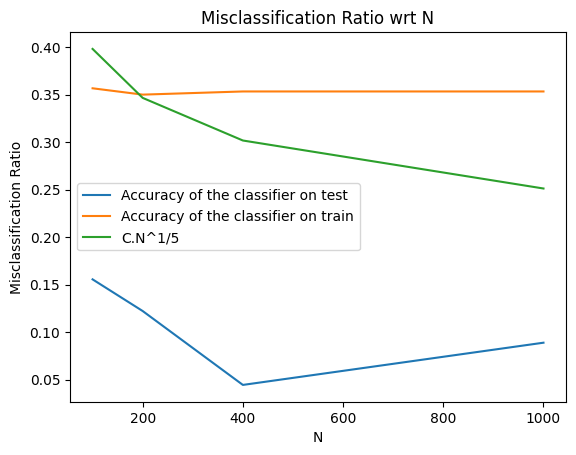

In [ ]:
plt.plot(N_list,accuracy_list_test, label='Accuracy of the classifier on test')
plt.plot(N_list,accuracy_list_train, label='Accuracy of the classifier on train')
plt.plot(N_list,[k**(-1/5) for k in N_list], label='C.N^1/5')
plt.xlabel('N')
plt.ylabel('Misclassification Ratio')
plt.title('Misclassification Ratio wrt N')
plt.legend()
plt.show()

## Alternatives

### Use of Neural network for the non parametric estimation

#### Definition of the class

##### DataSet class

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y, transform=None):
        """
        Args:
            X (torch.Tensor or np.ndarray): Features data.
            y (torch.Tensor or np.ndarray): Labels data.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.X = torch.tensor(X, dtype=torch.float32) if not isinstance(X, torch.Tensor) else X
        self.y = torch.tensor(y, dtype=torch.float32) if not isinstance(y, torch.Tensor) else y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = {'features': self.X[idx], 'labels': self.y[idx]}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
# Example data (random data for demonstration)
X = torch.randn(100, 10)  # 100 samples, 10 features each
y = torch.randn(100, 1)   # 100 labels (e.g., for regression)

# Create an instance of the custom dataset
dataset = CustomDataset(X, y)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
# Iterate over DataLoader
for batch in dataloader:
    features = batch['features']
    labels = batch['labels']
    print(f'Features shape: {features.shape}, Labels shape: {labels.shape}')

Features shape: torch.Size([16, 10]), Labels shape: torch.Size([16, 1])
Features shape: torch.Size([16, 10]), Labels shape: torch.Size([16, 1])
Features shape: torch.Size([16, 10]), Labels shape: torch.Size([16, 1])
Features shape: torch.Size([16, 10]), Labels shape: torch.Size([16, 1])
Features shape: torch.Size([16, 10]), Labels shape: torch.Size([16, 1])
Features shape: torch.Size([16, 10]), Labels shape: torch.Size([16, 1])
Features shape: torch.Size([4, 10]), Labels shape: torch.Size([4, 1])


##### Neural Network class

In [ ]:
class NeuralNet(nn.Module):

    def __init__(self,
                 input_dim,
                 output_dim,
                 hidden_linear_dim,
                 activation_functions,
                 loss,
                 optimizer,
                 learning_rate,
                 loss_space,
                 scale_gradient = False):
        super(NeuralNet, self).__init__()
        # Definition of the hidden layers
        self.hidden_layers = []
        for i in range(len(hidden_linear_dim)-1):
            if i == 0:
                self.hidden_layers.append(nn.Linear(in_features = input_dim,
                                          out_features = hidden_linear_dim[i]))
            self.hidden_layers.append(nn.Linear(in_features = hidden_linear_dim[i],
                                                out_features = hidden_linear_dim[i+1]))
        # Definition of the output layer
        self.output_layer = nn.Linear(in_features = hidden_linear_dim[-1],
                                      out_features = output_dim)
        # Definition of other parameters
        self.activation_functions = activation_functions
        self.loss = loss
        self.optimizer = optimizer
        self.learning_rate = learning_rate

        # Define number of iteration between two loss values save
        self.loss_space = loss_space
        # Determines wether or not the gradients will be scaled
        self.scale_gradient = scale_gradient

    def forward(self, x):
        assert len(self.activation_functions) == len(self.hidden_layers) + 1, \
            f"The number of activation functions must be equal to the number of hidden layers + 1 but got {len(self.activation_functions)} instead of {len(self.hidden_layers) + 1}"
        # Evaluation through hidden layers
        for layer,phi in zip(self.hidden_layers,
                          self.activation_functions):
            x = phi(layer(x))
        # Evaluation through output layer
        x = self.output_layer(x)
        x = self.activation_functions[-1](x)
        return x

    def fit(self,
            X_train,
            y_train,
            num_epochs,
            batch_size,
            mini_batch = True,
            overfit_check = True):
        self.num_epochs = num_epochs
        self.overfit_check = overfit_check
        loss_values = []
        if mini_batch:
            # Randomly select indices for the mini-batch
            num_samples = X_train.shape[1]
            indices = torch.randperm(num_samples)[:batch_size]
            # Extract the minibatches from X_train and y_train
            X_train_batch = X_train[indices, :]
            y_train_batch = y_train[indices, :]
        else :
            X_train_batch = X_train
            y_train_batch = y_train
        # Definition of the optimizer
        optimizer = self.optimizer(self.parameters(), lr = self.learning_rate)
        # Training step with checking for possible overfitting
        if overfit_check:
            loss_values_train = []
            loss_values_val = []
            # Split of the data between train and test set
            X_batch_train, X_batch_val, y_batch_train, y_batch_val = train_test_split(X_train_batch, y_train_batch, test_size=0.3)
            for epoch in range(num_epochs):
                # Defining training DataSet and mini-batches
                train_data_set = CustomDataset(X_batch_train, y_batch_train)
                train_loader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True)
                for batch in train_loader:
                    X_batch_train, y_batch_train = batch['features'], batch['labels']
                    if self.scale_gradient:
                        # Define scaler for automatic scaling of gradients
                        # Useful only with the use of GPU
                        scaler = GradScaler() if torch.cuda.is_available() else None
                        if scaler:
                            with autocast():
                                # Enable autocasting for mixed precision
                                y_pred_train = self.forward(X_batch_train)
                                loss_train = self.loss(y_pred_train, y_batch_train)
                            # Backward pass and optimization
                            optimizer.zero_grad()
                            scaler.scale(loss_train).backward()
                            scaler.step(optimizer)
                            scaler.update()
                    else:
                        y_pred_train = self.forward(X_batch_train)
                        loss_train = self.loss(y_pred_train, y_batch_train)
                        optimizer.zero_grad()
                        loss_train.backward()
                        optimizer.step()
                # Saving loss results every loss_space iterations
                if epoch % self.loss_space == 0:
                          print(f'Epoch number : {epoch}, Value of the loss : {loss_train.item()}')
                          loss_values_train.append(loss_train.item())
                          self.eval()  # Set the model to evaluation mode
                          with torch.no_grad():
                              y_pred_test = self(X_batch_val)
                              loss_test = self.loss(y_pred_test, y_batch_val)
                          loss_values_val.append(loss_test.item())
            self.loss_values = [loss_values_train, loss_values_val]
        else :
            loss_values = []
            for epoch in range(num_epochs):
                # Defining training DataSet and mini-batches
                train_data_set = CustomDataset(X_train_batch, y_train_batch)
                train_loader = DataLoader(train_data_set, batch_size=batch_size, shuffle=True)
                for batch in train_loader:
                    X_batch_train, y_batch_train = batch['features'], batch['labels']
                    if self.scale_gradient:
                        scaler = GradScaler() if torch.cuda.is_available() else None
                        if scaler:
                            with autocast():
                                # Enable autocasting for mixed precision
                                y_pred_train = self.forward(X_batch_train)
                                loss_train = self.loss(y_pred_train, y_batch_train)
                            # Backward pass and optimization
                            optimizer.zero_grad()
                            scaler.scale(loss_train).backward()
                            scaler.step(optimizer)
                            scaler.update()
                    else:
                        y_pred_train = self.forward(X_batch_train)
                        loss_train = self.loss(y_pred_train, y_batch_train)
                        optimizer.zero_grad()
                        loss_train.backward()
                        optimizer.step()
                # Saving loss results every loss_space iterations
                if epoch % self.loss_space == 0:
                          print(f'Epoch number : {epoch}, Value of the loss : {loss_train.item()}')
                          loss_values.append(loss_train.item())
            self.loss_values = loss_values

    def plot_loss(self):
        if self.overfit_check:
            plt.figure(figsize=(12, 6))
            plt.plot([k for k in np.arange(self.num_epochs) if k % self.loss_space == 0],
                     self.loss_values[0],
                     label = 'Training Loss')
            plt.plot([k for k in np.arange(self.num_epochs) if k % self.loss_space == 0],
                     self.loss_values[1],
                     label = 'Test Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Training and Test Loss')
            plt.legend()
            plt.show()
        else :
            plt.figure(figsize=(12, 6))
            plt.plot([k for k in np.arange(self.num_epochs)
                      if k % self.loss_space == 0], self.loss_values)
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Training Loss')
            plt.show()

    def tuning(self):
        return self

#### Example Test

In [ ]:
X_train = Xtrain[:,ytrain == 1]
y_train = np.ones((X_train.shape[0], X_train.shape[1]))

X_train = torch.from_numpy(X_train).float() # Because weights of the model are of type Float
y_train = torch.from_numpy(y_train).float()

X_train, y_train = X_train.T, y_train.T

In [ ]:
# Definition of parameters
input_dim = X_train.shape[1]
output_dim = y_train.shape[1]
hidden_linear_dim = [64,128,32]
activation_functions = [nn.Softplus(), nn.Softplus(), nn.Softplus(),nn.Softplus()]
loss = F.mse_loss
optimizer = torch.optim.Adam
learning_rate = 0.001
loss_space = 10

model = NeuralNet(input_dim,
                  output_dim,
                  hidden_linear_dim,
                  activation_functions,
                  loss,
                  optimizer,
                  learning_rate,
                  loss_space)

In [ ]:
num_epoch = 100
batch_size = 10

model.fit(X_train,
          y_train,
          num_epoch,
          batch_size)

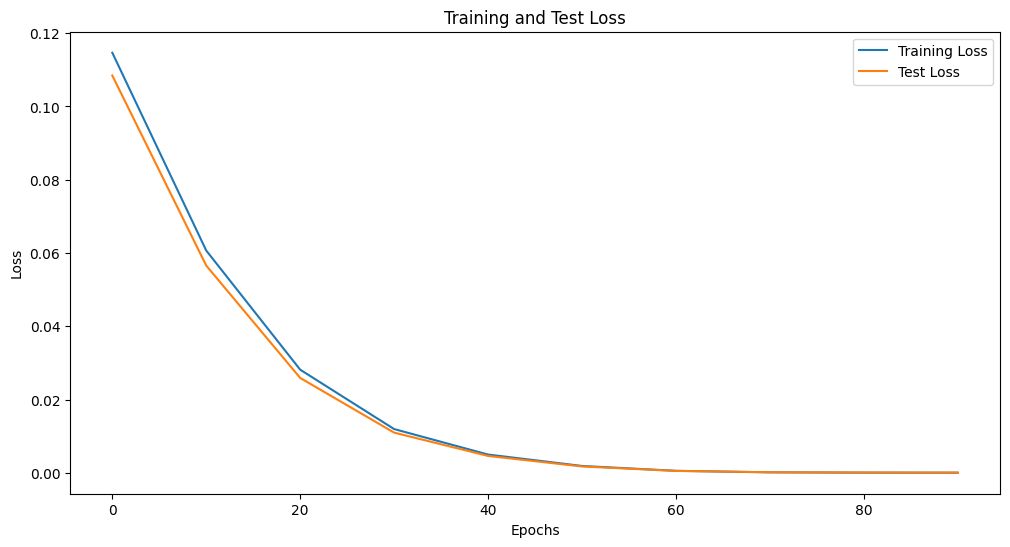

In [ ]:
model.plot_loss()

#### Modified Functions

In [ ]:
def zfun_NN(
    Mx : np.ndarray,
    delta : float
    )-> np.ndarray :
################################################################################
################################################################################
#### Function used to compute the succesive differences of order 1
####
#### Mx : Data matrix, containing sampled trajectories along rows.
#### Delta : TimeStep used to normalize the differences
################################################################################
################################################################################
    diffs = np.diff(Mx, axis=0)
    #result = (diffs[1:, :] / delta).flatten(order='F')
    result = (diffs / delta)
    #print("iZ shape : ",result.shape)
    return result
                          ###########################

def ufun_NN(
    Mx : np.ndarray,
    delta : float
    )-> np.ndarray :
################################################################################
################################################################################
#### Computes the succesive differences of order 2
####
#### Mx : Data matrix, containing sampled trajectories along rows.
#### Delta : TimeStep used to normalize the differences
################################################################################
################################################################################
    diffs = np.diff(Mx, axis=0)**2
    #result = (diffs[1:, :] / delta).flatten(order='F')
    result = (diffs / delta)
    #print("U shape : ",result.shape)
    return result

                          ###########################

def optimfun_NN(
    Mx : np.ndarray,
    Z: np.ndarray,
    num_epochs,
    batch_size,
    K,
    M = 1,
    overfit_check = True,
    plot = True,
    hidden_dim = [64,128,32]
    ) -> np.ndarray:
    print("Value of K :", K.item())
    Mx_copy = Mx.clone()
    Z_copy = Z.clone()
    # Definition of parameters
    input_dim = Mx.shape[1]
    output_dim = Z.shape[1]
    hidden_linear_dim = [hidden_dim[0]]*M
    hidden_linear_dim.extend([hidden_dim[1]]*K)
    hidden_linear_dim.extend([hidden_dim[2]]*M)
    activation_functions = [nn.Softplus()]*(len(hidden_linear_dim) + 1)
    loss = F.mse_loss
    optimizer = torch.optim.Adam
    learning_rate = 0.008
    loss_space = 10
    # Initilisation of the model
    model = NeuralNet(input_dim,
                      output_dim,
                      hidden_linear_dim,
                      activation_functions,
                      loss,
                      optimizer,
                      learning_rate,
                      loss_space)
    # Model fitting
    model.fit(Mx_copy, Z_copy, num_epochs, batch_size,
              overfit_check = overfit_check)
    if plot:
        model.plot_loss()
    return model

def gamma_pen_NN(
    X : np.ndarray,
    model,
    c : float,
    K : int,
    M : int,
    Z : np.ndarray,
    n : int,
    N : int
    )-> float:
################################################################################
################################################################################
#### Computes the penalized criterion in order to select a dimension K.
####
#### a : Coefficients of the B-Spline basis
#### B : B-Spline basis
#### Z : Matrix of successive differences
#### K : Number of non-zero knots
#### M : Such that K+M = desired number of B-Spline functions
#### c : Coefficient of the penalization
#### n : Number of discretization
#### N : Number of observations considered
################################################################################
################################################################################
    result = 0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for j in range(X.shape[0]):
            result += torch.sum((Z[j, :] - model(X[j, :])) ** 2)
        result = result / (n * N)
    return result + c * (np.log(N) * (K + M) / N)
                          ###########################

def selectdimdrift_NN(
    X : np.ndarray,
    iZ : np.ndarray,
    c : float,
    SetKspline : np.ndarray,
    M : int,
    num_epochs,
    batch_size,
    overfit_check = True,
    plot = True
    )-> int:
################################################################################
################################################################################
#### Returns the value of K that minimizes the penalized criterion
####
#### X : Matrix of observed trajectories
#### iZ : matrix of successive differences
#### c : Coefficient of the penalization
#### SetKspline : Possible values for dimension K
#### M : Such that K+M = desired number of B-Spline functions
#### Inf_bound : Lower bound of the interval considered
#### Sup_bound : Upper bound of the interval considered
#### delta : TimeStep of discretization
#### Lconst : Constant defining the Upper Bound of Approximation
################################################################################
################################################################################
    N = X.shape[1]
    n = X.shape[0]
    models = [optimfun_NN(X, iZ, num_epochs, batch_size, k, M, overfit_check, plot) for k in SetKspline]
    gpen_vec = [gamma_pen_NN(X, model, c, k, M, iZ, n, N) for model, k in zip(models,SetKspline)]
    i_min = np.argmin(gpen_vec)
    print("-----Selected K value :",SetKspline[i_min].item())
    return models[i_min]

                          ###########################

def gamma_pen2_NN(
    X : np.ndarray,
    model,
    c : float,
    K : int,
    M : int,
    U : np.ndarray,
    n : int,
    N : int
    )-> float:
################################################################################
################################################################################
#### Computes the penalized criterion in order to select a dimension K.
####
#### a : Coefficients of the B-Spline basis
#### B : B-Spline basis
#### U : Matrix of successive differences
#### K : Number of non-zero knots
#### M : Such that K+M = desired number of B-Spline functions
#### c : Coefficient of the penalization
#### n : Number of discretization
#### N : Number of observations considered
################################################################################
################################################################################
    result = 0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for j in range(X.shape[0]):
            result += torch.sum((U[j, :] - model(X[j, :])) ** 2)
        result = result / (n * N)
    return result + c * (np.log(N) * (K + M) / N)

                          ###########################

def selectdimdiff_NN(
    X : np.ndarray,
    U : np.ndarray,
    c : float,
    SetKspline : np.ndarray,
    M : int,
    num_epochs,
    batch_size,
    overfit_check = True,
    plot = True
    )-> int:
################################################################################
################################################################################
#### Returns the value of K that minimizes the penalized criterion
####
#### X : Matrix of observed trajectories
#### iZ : matrix of successive differences
#### c : Coefficient of the penalization
#### SetKspline : Possible values for dimension K
#### M : Such that K+M = desired number of B-Spline functions
#### Inf_bound : Lower bound of the interval considered
#### Sup_bound : Upper bound of the interval considered
#### delta : TimeStep of discretization
#### Lconst : Constant defining the Upper Bound of Approximation
################################################################################
################################################################################
    N = X.shape[1]
    n = X.shape[0]
    models = [optimfun_NN(X, U, num_epochs, batch_size, k, M, overfit_check, plot) for k in SetKspline]
    gpen_vec = [gamma_pen2_NN(X, model, c, k, M, U, n, N) for model, k in zip(models,SetKspline)]
    i_min = np.argmin(gpen_vec)
    print("-----Selected K value :",SetKspline[i_min].item())
    return models[i_min]

                          ###########################

#### Neural network class using Lightning for Hyperparameters tuning

##### Dataset class

In [ ]:
class CustomDataset_Lightning(Dataset):
    def __init__(self, X, y, transform=None):
        """
        Args:
            X (torch.Tensor or np.ndarray): Features data.
            y (torch.Tensor or np.ndarray): Labels data.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.X = torch.tensor(X, dtype=torch.float32) if not isinstance(X, torch.Tensor) else X
        self.y = torch.tensor(y, dtype=torch.float32) if not isinstance(y, torch.Tensor) else y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = {'features': self.X[idx], 'labels': self.y[idx]}

        if self.transform:
            sample = self.transform(sample)

        return sample
class CustomDataModule_Lightning(L.LightningDataModule):
    def __init__(self, X_train, y_train, X_test, y_test, batch_size, num_workers = 4):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        # Spliting data into Train and Validation data
        train_size = int(0.8 * len(self.X_train))  # 80% for training
        val_size = len(self.X_train) - train_size  # 20% for validation
        train_dataset = CustomDataset_Lightning(self.X_train, self.y_train)
        self.train_data, self.val_data = random_split(train_dataset, [train_size, val_size])

        # Test data
        self.test_data = CustomDataset_Lightning(self.X_test, self.y_test)

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size, num_workers=self.num_workers)


##### Neural Net class

In [ ]:
class NeuralNet_Lightning(pl.LightningModule):
    def __init__(self,
                 configuration,
                 scale_gradient = False,
                 overfit_check = True):
        super(NeuralNet_Lightning, self).__init__()
        # Definition of the hidden layers
        self.input_dim = configuration['input_dim']
        self.output_dim = configuration['output_dim']
        self.hidden_layers = nn.ModuleList()
        hidden_linear_dim = configuration['hidden_linear_dim']
        for i in range(len(hidden_linear_dim)-1):
            if i == 0:
                self.hidden_layers.append(nn.Linear(in_features = self.input_dim,
                                          out_features = hidden_linear_dim[i]))
            self.hidden_layers.append(nn.Linear(in_features = hidden_linear_dim[i],
                                                out_features = hidden_linear_dim[i+1]))
        # Definition of the output layer
        self.output_layer = nn.Linear(in_features = hidden_linear_dim[-1],
                                      out_features = self.output_dim)
        # Definition of other parameters
        self.activation_functions = configuration['activation_functions']
        self.loss = configuration['loss']
        self.optimizer = configuration['optimizer']
        self.learning_rate = configuration['learning_rate']
        self.learning_rate = 1e-4
        # Define number of iteration between two loss values save
        self.loss_space = configuration['loss_space']
        # Determines wether or not the gradients will be scaled
        self.scale_gradient = scale_gradient

        self.eval_loss = []

        self.num_epochs = configuration['num_epochs']
        self.batch_size = configuration['batch_size']
        self.overfit_check = overfit_check

    def forward(self, x):
        assert len(self.activation_functions) == len(self.hidden_layers) + 1, \
            f"The number of activation functions must be equal to the number of hidden layers + 1 but got {len(self.activation_functions)} instead of {len(self.hidden_layers) + 1}"
        # Evaluation through hidden layers
        for layer,phi in zip(self.hidden_layers,
                          self.activation_functions):
            x = phi(layer(x))
        # Evaluation through output layer
        x = self.output_layer(x)
        x = self.activation_functions[-1](x)
        return x

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self.forward(x)
        loss = self.loss(logits, y)

        self.log("ptl/train_loss", loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self.forward(x)
        loss = self.loss(logits, y)
        self.eval_loss.append(loss)
        return {"val_loss": loss}

    def on_validation_epoch_end(self):
        avg_loss = torch.stack(self.eval_loss).mean()
        self.log("avg_val_loss", avg_loss, sync_dist=True)
        self.eval_loss.clear()

    def configure_optimizers(self):
        optimizer = self.optimizer(self.parameters(), lr=self.learning_rate)
        return optimizer

    # def setup_dataloader(self, X_train, y_train, X_val, y_val, batch_size):
    #     train_dataset = CustomDataset_Lightning(X_train, y_train)
    #     val_dataset = CustomDataset_Lightning(X_val, y_val)
    #     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    #     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    #     return train_loader, val_loader

# Once fine tuning is done, we can fit our model with the right configuration
    def fit(self,
            X_train,
            y_train,
            configuration,
            mini_batch = True,
            overfit_check = True):
        loss_values = []
        if mini_batch:
            # Randomly select indices for the mini-batch
            num_samples = X_train.shape[1]
            indices = torch.randperm(num_samples)[:self.batch_size]
            # Extract the minibatches from X_train and y_train
            X_train_batch = X_train[indices, :]
            y_train_batch = y_train[indices, :]
        else :
            X_train_batch = X_train
            y_train_batch = y_train
        # Definition of the optimizer
        optimizer = self.optimizer(self.parameters(), lr = self.learning_rate)
        # Training step with checking for possible overfitting
        if overfit_check:
            loss_values_train = []
            loss_values_val = []
            # Split of the data between train and test set
            X_batch_train, X_batch_val, y_batch_train, y_batch_val = train_test_split(X_train_batch, y_train_batch, test_size=0.3)
            for epoch in range(self.num_epochs):
                # Defining training DataSet and mini-batches
                train_data_set = CustomDataset_Lightning(X_batch_train, y_batch_train)
                train_loader = DataLoader(train_data_set, batch_size = self.batch_size, shuffle=True)
                for batch in train_loader:
                    X_batch_train, y_batch_train = batch['features'], batch['labels']
                    if self.scale_gradient:
                        # Define scaler for automatic scaling of gradients
                        # Useful only with the use of GPU
                        scaler = GradScaler() if torch.cuda.is_available() else None
                        if scaler:
                            with autocast():
                                # Enable autocasting for mixed precision
                                y_pred_train = self.forward(X_batch_train)
                                loss_train = self.loss(y_pred_train, y_batch_train)
                            # Backward pass and optimization
                            optimizer.zero_grad()
                            scaler.scale(loss_train).backward()
                            scaler.step(optimizer)
                            scaler.update()
                    else:
                        y_pred_train = self.forward(X_batch_train)
                        loss_train = self.loss(y_pred_train, y_batch_train)
                        optimizer.zero_grad()
                        loss_train.backward()
                        optimizer.step()
                # Saving loss results every loss_space iterations
                if epoch % self.loss_space == 0:
                          print(f'Epoch number : {epoch}, Value of the loss : {loss_train.item()}')
                          loss_values_train.append(loss_train.item())
                          self.eval()  # Set the model to evaluation mode
                          with torch.no_grad():
                              y_pred_test = self(X_batch_val)
                              loss_test = self.loss(y_pred_test, y_batch_val)
                          loss_values_val.append(loss_test.item())
            self.loss_values = [loss_values_train, loss_values_val]
        else :
            loss_values = []
            for epoch in range(self.num_epochs):
                # Defining training DataSet and mini-batches
                train_data_set = CustomDataset_Lightning(X_train_batch, y_train_batch)
                train_loader = DataLoader(train_data_set, batch_size = self.batch_size, shuffle=True)
                for batch in train_loader:
                    X_batch_train, y_batch_train = batch['features'], batch['labels']
                    if self.scale_gradient:
                        scaler = GradScaler() if torch.cuda.is_available() else None
                        if scaler:
                            with autocast():
                                # Enable autocasting for mixed precision
                                y_pred_train = self.forward(X_batch_train)
                                loss_train = self.loss(y_pred_train, y_batch_train)
                            # Backward pass and optimization
                            optimizer.zero_grad()
                            scaler.scale(loss_train).backward()
                            scaler.step(optimizer)
                            scaler.update()
                    else:
                        y_pred_train = self.forward(X_batch_train)
                        loss_train = self.loss(y_pred_train, y_batch_train)
                        optimizer.zero_grad()
                        loss_train.backward()
                        optimizer.step()
                # Saving loss results every loss_space iterations
                if epoch % self.loss_space == 0:
                          print(f'Epoch number : {epoch}, Value of the loss : {loss_train.item()}')
                          loss_values.append(loss_train.item())
            self.loss_values = loss_values

    def plot_loss(self):
        if self.overfit_check:
            plt.figure(figsize=(12, 6))
            plt.plot([k for k in np.arange(self.num_epochs) if k % self.loss_space == 0],
                     self.loss_values[0],
                     label = 'Training Loss')
            plt.plot([k for k in np.arange(self.num_epochs) if k % self.loss_space == 0],
                     self.loss_values[1],
                     label = 'Test Loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Training and Test Loss')
            plt.legend()
            plt.show()
        else :
            plt.figure(figsize=(12, 6))
            plt.plot([k for k in np.arange(self.num_epochs)
                      if k % self.loss_space == 0], self.loss_values)
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Training Loss')
            plt.show()

    def train_dataloader(self):
        return self.DataLoader

In [ ]:
def get_model_config(configuration):
        K = configuration['K'] # Retrieve and remove 'K' from the config
        M = 1  # Define M based on your requirement or make it configurable
        # Generate the hidden_linear_dim based on K, M, and hidden_dim
        hidden_linear_dim = [configuration["hidden_dim"][0]] * M
        hidden_linear_dim.extend([configuration["hidden_dim"][1]] * K)
        hidden_linear_dim.extend([configuration["hidden_dim"][2]] * M)
        configuration["hidden_linear_dim"] = hidden_linear_dim
        configuration["activation_functions"] = [configuration["activation_functions"]] * (len(hidden_linear_dim) + 1)
        configuration.pop("K", None)

        return configuration

In [ ]:
search_space = {
            "input_dim": Xtrain.shape[1],
            "output_dim": ytrain.shape[1],
            "K": 3,  # Example choices for K
            "hidden_dim": [64, 128, 64],
                # [128, 256, 128],
                # [256, 512, 256],
            "activation_functions": nn.Softplus(),
                # nn.ReLU(),
                # nn.Sigmoid(),
                # nn.LeakyReLU(),
            "loss": nn.MSELoss(),
            "optimizer": torch.optim.Adam,
                # torch.optim.SGD,
                # torch.optim.RMSprop
            "learning_rate": 1e-4,
            "num_epochs": 100,
            "loss_space": 100,
            "batch_size": 128,
        }
configuration = get_model_config(search_space)

In [ ]:
train_dataset = CustomDataset_Lightning(Xtrain[:n-1,:].T, iZtrain.T)
model = NeuralNet_Lightning(configuration)
model.DataLoader = DataLoader(train_dataset, batch_size=model.batch_size, shuffle=True)
trainer = pl.Trainer(max_epochs=50,
                  log_every_n_steps=2,
                  strategy="auto",
                  accelerator="auto",
                  devices="auto")
# trainer = L.Trainer(max_epochs=50, log_every_n_steps=2, strategy="auto", accelerator="auto", devices="auto", callbacks = ["val_loss"])

tuner = pl.tuner.Tuner(trainer)

lr_find_results = tuner.lr_find(model,
                                # train_dataloader=dataloader,
                                min_lr=1e-4,
                                max_lr=0.01,)
                                # early_stop_treshold=True)
new_lr = lr_find_results.suggestion()
print(f'Optimal Learning rate : {new_lr}')
model.learning_rate = new_lr
model.fit(Xtrain, ytrain, configuration)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=2). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

TypeError: linear(): argument 'input' (position 1) must be Tensor, not str

##### Tuning module to fine tune Hyperparmeters of the model

In [ ]:
class TuningModule:
    def train_func(self, X_train, y_train, X_test, y_test, configuration):
        # Create your custom DataModule with the provided batch size from config
        data_module = CustomDataModule_Lightning(
            X_train,
            y_train,
            X_test,
            y_test,
            batch_size=configuration["batch_size"]
        )

        # Initialize your model using the configuration provided
        model = NeuralNet_Lightning(configuration)

        # Set up the Trainer with Ray DDP and Ray Train callback
        trainer = pl.Trainer(
            max_epochs=100,
            devices="auto",  # Automatically select the available devices
            accelerator="auto",  # Automatically select the accelerator (CPU/GPU)
            strategy=RayDDPStrategy(),  # Distributed data parallel strategy using Ray
            callbacks=[RayTrainReportCallback()],
            plugins=[RayLightningEnvironment()],
            enable_progress_bar=False,  # Disable progress bar for efficiency in distributed setup
        )

        trainer = prepare_trainer(trainer)
        trainer.fit(model, datamodule=data_module)

    def get_model_config(self, configuration):
        K = configuration['K'][0]  # Retrieve and remove 'K' from the config
        M = 1  # Define M based on your requirement or make it configurable
        # Generate the hidden_linear_dim based on K, M, and hidden_dim
        hidden_linear_dim = [configuration["hidden_dim"][0][0]] * M
        hidden_linear_dim.extend([configuration["hidden_dim"][0][1]] * K)
        hidden_linear_dim.extend([configuration["hidden_dim"][0][2]] * M)
        configuration["hidden_linear_dim"] = hidden_linear_dim
        configuration["activation_functions"] = [configuration["activation_functions"][0]] * (len(hidden_linear_dim) + 1)
        configuration.pop("K", None)

        return configuration

    def tuning(self, X_train, y_train, X_test, y_test, search_space, num_samples=100, num_epochs=10):
        # Apply the model configuration to include 'K'
        search_space = self.get_model_config(search_space)

        # Define the scaling configuration for Ray
        scaling_config = ScalingConfig(
            num_workers=2,  # Reduce the number of workers
            use_gpu=False,
            resources_per_worker={"CPU": 1}  # Match the available resources
        )

        # Define the run configuration
        run_config = RunConfig(
            checkpoint_config = CheckpointConfig(
                num_to_keep=2,
                checkpoint_score_attribute="avg_val_loss",
                checkpoint_score_order="min",
            ),
        )
        # Create an ASHA scheduler
        scheduler = ASHAScheduler(max_t=num_epochs, grace_period=1, reduction_factor=2)

        # Define the TorchTrainer with the train_func
        ray_trainer = TorchTrainer(
            train_loop_per_worker=lambda config: self.train_func(X_train,
                                                                 y_train,
                                                                 X_test,
                                                                 y_test,
                                                                 config),
            scaling_config=scaling_config,
            run_config=run_config,
        )

        # Set up Ray Tuner
        tuner = tune.Tuner(
            ray_trainer,
            param_space={"train_loop_config": search_space},
            tune_config=tune.TuneConfig(
                metric="avg_val_loss",
                mode="min",
                num_samples=num_samples,
                scheduler=scheduler,
            ),
        )

        # Return the tuning results
        return tuner.fit()


##### Tuning of the Model

In [ ]:
# Prediction
t0 = 0;T = 1;x0 = 0;n = 100
Ni_train_list = np.array([500,500,500])
Ni_test_list = np.array([30,30,30])
labels = np.array([1,2,3])
theta = np.array([-4,1,4])

# Prediction
Xtrain, ytrain, Xtest, ytest = simulation_sde(t0, T, x0, n, Ni_train_list,
                                              Ni_test_list, labels,
                                              b,sigma, theta, plot = False)
iXtrain = Xtrain[:, ytrain == 1]
iXtest = Xtest[:, ytest == 1]
n = iXtrain.shape[0]
TimeStep = 1/n
iZtrain = zfun_NN(iXtrain, TimeStep)
iZtest = zfun_NN(iXtest, TimeStep)

Xtrain = torch.from_numpy(iXtrain[:n-1, :].T).float()
ytrain = torch.from_numpy(iZtrain.T).float()
Xtest = torch.from_numpy(iXtest[:n-1, :].T).float()
ytest = torch.from_numpy(iZtest.T).float()

In [ ]:
search_space = {
            "input_dim": tune.choice([Xtrain.shape[1]]),
            "output_dim": tune.choice([ytrain.shape[1]]),
            "K": tune.choice([3]),  # Example choices for K
            "hidden_dim": tune.choice([
                [64, 128, 64]
                # [128, 256, 128],
                # [256, 512, 256]
            ]),
            "activation_functions": tune.choice([
                # nn.ReLU(),
                # nn.Sigmoid(),
                # nn.LeakyReLU(),
                nn.Softplus()
            ]),
            "loss": tune.choice([
                nn.MSELoss(),
            ]),
            "optimizer": tune.choice([
                torch.optim.Adam
                # torch.optim.SGD,
                # torch.optim.RMSprop
            ]),
            "learning_rate": tune.choice([1e-4, 1e-3, 1e-2, 1e-1]),
            "num_epochs": tune.choice([100]),
            "loss_space": tune.choice([100]),
            "batch_size": tune.choice([128]),
        }

tuning_module = TuningModule()
results = tuning_module.tuning(Xtrain, ytrain, Xtest, ytest, search_space)

+---------------------------------------------------------------------+
| Configuration for experiment     TorchTrainer_2024-08-13_01-19-51   |
+---------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator              |
| Scheduler                        AsyncHyperBandScheduler            |
| Number of trials                 100                                |
+---------------------------------------------------------------------+

View detailed results here: /root/ray_results/TorchTrainer_2024-08-13_01-19-51
To visualize your results with TensorBoard, run: `tensorboard --logdir /tmp/ray/session_2024-08-12_23-33-04_265577_332/artifacts/2024-08-13_01-19-51/TorchTrainer_2024-08-13_01-19-51/driver_artifacts`

Trial status: 100 PENDING
Current time: 2024-08-13 01:19:55. Total running time: 4s
Logical resource usage: 0/2 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------------

(RayTrainWorker pid=35985) Setting up process group for: env:// [rank=0, world_size=2]
(TorchTrainer pid=35915) Started distributed worker processes: 
(TorchTrainer pid=35915) - (node_id=5b339834ef4f25ec007a798ce4325760212fd0b3cbb81ca58f0bb5b8, ip=172.28.0.12, pid=35985) world_rank=0, local_rank=0, node_rank=0
(TorchTrainer pid=35915) - (node_id=5b339834ef4f25ec007a798ce4325760212fd0b3cbb81ca58f0bb5b8, ip=172.28.0.12, pid=35986) world_rank=1, local_rank=1, node_rank=0
(RayTrainWorker pid=35985) GPU available: False, used: False
(RayTrainWorker pid=35985) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=35985) HPU available: False, using: 0 HPUs
(RayTrainWorker pid=35985) 2024-08-13 01:20:18.945213: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(RayTrainWorker pid=35985) 2024-08-13 01:20:18.976530: E external/local_xla/xla/stream_executor/cu


Trial status: 1 RUNNING | 99 PENDING
Current time: 2024-08-13 01:20:25. Total running time: 34s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 237f4_00000 with avg_val_loss=61.90433120727539 and params={'train_loop_config': {'input_dim': 99, 'output_dim': 99, 'hidden_dim': [64, 128, 64], 'activation_functions': [Softplus(beta=1.0, threshold=20.0), Softplus(beta=1.0, threshold=20.0), Softplus(beta=1.0, threshold=20.0), Softplus(beta=1.0, threshold=20.0), Softplus(beta=1.0, threshold=20.0), Softplus(beta=1.0, threshold=20.0)], 'loss': MSELoss(), 'optimizer': <class 'torch.optim.adam.Adam'>, 'learning_rate': 0.0001, 'num_epochs': 100, 'loss_space': 100, 'batch_size': 128, 'hidden_linear_dim': [64, 128, 128, 128, 64]}}
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

2024-08-13 01:20:27,098	WARNING experiment_state.py:206 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds and may become a bottleneck. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this warning by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0). Set it to 0 to completely suppress this warning.
(RayTrainWorker pid=35986) /usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker 


Trial TorchTrainer_237f4_00000 completed after 10 iterations at 2024-08-13 01:20:32. Total running time: 41s
+-------------------------------------------------------------+
| Trial TorchTrainer_237f4_00000 result                       |
+-------------------------------------------------------------+
| checkpoint_dir_name                       checkpoint_000009 |
| time_this_iter_s                                    0.79612 |
| time_total_s                                        28.0658 |
| training_iteration                                       10 |
| avg_val_loss                                       61.58793 |
| epoch                                                     9 |
| ptl/train_loss                                     62.59715 |
| step                                                     20 |
+-------------------------------------------------------------+

Trial TorchTrainer_237f4_00001 started with configuration:
+-------------------------------------------------------------

(RayTrainWorker pid=36938) Setting up process group for: env:// [rank=0, world_size=2]
(RayTrainWorker pid=35986) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-08-13_01-19-51/TorchTrainer_237f4_00000_0_batch_size=128,hidden_dim=64_128_64,input_dim=99,learning_rate=0.0001,loss=ref_ph_d6d015d4,loss_space=1_2024-08-13_01-19-52/checkpoint_000009) [repeated 9x across cluster]
(TorchTrainer pid=36864) Started distributed worker processes: 
(TorchTrainer pid=36864) - (node_id=5b339834ef4f25ec007a798ce4325760212fd0b3cbb81ca58f0bb5b8, ip=172.28.0.12, pid=36938) world_rank=0, local_rank=0, node_rank=0
(TorchTrainer pid=36864) - (node_id=5b339834ef4f25ec007a798ce4325760212fd0b3cbb81ca58f0bb5b8, ip=172.28.0.12, pid=36939) world_rank=1, local_rank=1, node_rank=0



Trial status: 1 TERMINATED | 1 RUNNING | 98 PENDING
Current time: 2024-08-13 01:20:55. Total running time: 1min 4s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 237f4_00000 with avg_val_loss=61.587928771972656 and params={'train_loop_config': {'input_dim': 99, 'output_dim': 99, 'hidden_dim': [64, 128, 64], 'activation_functions': [Softplus(beta=1.0, threshold=20.0), Softplus(beta=1.0, threshold=20.0), Softplus(beta=1.0, threshold=20.0), Softplus(beta=1.0, threshold=20.0), Softplus(beta=1.0, threshold=20.0), Softplus(beta=1.0, threshold=20.0)], 'loss': MSELoss(), 'optimizer': <class 'torch.optim.adam.Adam'>, 'learning_rate': 0.0001, 'num_epochs': 100, 'loss_space': 100, 'batch_size': 128, 'hidden_linear_dim': [64, 128, 128, 128, 64]}}
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(RayTrainWorker pid=36938) GPU available: False, used: False
(RayTrainWorker pid=36938) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=36938) HPU available: False, using: 0 HPUs
(RayTrainWorker pid=36938) 2024-08-13 01:20:57.085304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(RayTrainWorker pid=36938) 2024-08-13 01:20:57.145224: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(RayTrainWorker pid=36938) 2024-08-13 01:20:57.163445: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
(RayTrainWorker pid=36938) 2024-08-13 01:20:59.325877: W tensorflow/compiler/tf2tensorrt/uti


Trial TorchTrainer_237f4_00001 completed after 1 iterations at 2024-08-13 01:21:01. Total running time: 1min 10s
+-------------------------------------------------------------+
| Trial TorchTrainer_237f4_00001 result                       |
+-------------------------------------------------------------+
| checkpoint_dir_name                       checkpoint_000000 |
| time_this_iter_s                                   18.31774 |
| time_total_s                                       18.31774 |
| training_iteration                                        1 |
| avg_val_loss                                        61.9199 |
| epoch                                                     0 |
| ptl/train_loss                                     59.73727 |
| step                                                      2 |
+-------------------------------------------------------------+

Trial TorchTrainer_237f4_00002 started with configuration:
+---------------------------------------------------------

(RayTrainWorker pid=37283) Setting up process group for: env:// [rank=0, world_size=2]
(RayTrainWorker pid=36939) /usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
(RayTrainWorker pid=36939)   warnings.warn(_create_warning_msg(
(RayTrainWorker pid=36939) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-08-13_01-19-51/TorchTrainer_237f4_00001_1_batch_size=128,hidden_dim=64_128_64,input_dim=99,learning_rate=0.0010,loss=ref_ph_d6d015d4,loss_space=1_2024-08-13_01-19-52/checkpoint_000000)
(TorchTrainer pid=37209) Started distributed worker processes: 
(T


Trial status: 2 TERMINATED | 1 RUNNING | 97 PENDING
Current time: 2024-08-13 01:21:25. Total running time: 1min 34s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 237f4_00000 with avg_val_loss=61.587928771972656 and params={'train_loop_config': {'input_dim': 99, 'output_dim': 99, 'hidden_dim': [64, 128, 64], 'activation_functions': [Softplus(beta=1.0, threshold=20.0), Softplus(beta=1.0, threshold=20.0), Softplus(beta=1.0, threshold=20.0), Softplus(beta=1.0, threshold=20.0), Softplus(beta=1.0, threshold=20.0), Softplus(beta=1.0, threshold=20.0)], 'loss': MSELoss(), 'optimizer': <class 'torch.optim.adam.Adam'>, 'learning_rate': 0.0001, 'num_epochs': 100, 'loss_space': 100, 'batch_size': 128, 'hidden_linear_dim': [64, 128, 128, 128, 64]}}
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(RayTrainWorker pid=37283) 2024-08-13 01:21:27.188361: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
(RayTrainWorker pid=37283) 
(RayTrainWorker pid=37283)   | Name          | Type       | Params | Mode 
(RayTrainWorker pid=37283) -----------------------------------------------------
(RayTrainWorker pid=37283) 0 | hidden_layers | ModuleList | 56.0 K | train
(RayTrainWorker pid=37283) 1 | output_layer  | Linear     | 6.4 K  | train
(RayTrainWorker pid=37283) 2 | loss          | MSELoss    | 0      | train
(RayTrainWorker pid=37283) -----------------------------------------------------
(RayTrainWorker pid=37283) 62.4 K    Trainable params
(RayTrainWorker pid=37283) 0         Non-trainable params
(RayTrainWorker pid=37283) 62.4 K    Total params
(RayTrainWorker pid=37283) 0.250     Total estimated model params size (MB)
(RayTrainWorker pid=37283) 8         Modules in train mode
(RayTrainWorker pid=37283) 0         Modules in eval mode
(Ray


Trial TorchTrainer_237f4_00002 completed after 10 iterations at 2024-08-13 01:21:39. Total running time: 1min 47s
+-------------------------------------------------------------+
| Trial TorchTrainer_237f4_00002 result                       |
+-------------------------------------------------------------+
| checkpoint_dir_name                       checkpoint_000009 |
| time_this_iter_s                                    0.80805 |
| time_total_s                                       27.72285 |
| training_iteration                                       10 |
| avg_val_loss                                       61.26975 |
| epoch                                                     9 |
| ptl/train_loss                                      61.7098 |
| step                                                     20 |
+-------------------------------------------------------------+

Trial TorchTrainer_237f4_00003 started with configuration:
+--------------------------------------------------------

(RayTrainWorker pid=38213) Setting up process group for: env:// [rank=0, world_size=2]
(RayTrainWorker pid=37283) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-08-13_01-19-51/TorchTrainer_237f4_00002_2_batch_size=128,hidden_dim=64_128_64,input_dim=99,learning_rate=0.0001,loss=ref_ph_d6d015d4,loss_space=1_2024-08-13_01-19-52/checkpoint_000009) [repeated 7x across cluster]
(TorchTrainer pid=38138) Started distributed worker processes: 
(TorchTrainer pid=38138) - (node_id=5b339834ef4f25ec007a798ce4325760212fd0b3cbb81ca58f0bb5b8, ip=172.28.0.12, pid=38213) world_rank=0, local_rank=0, node_rank=0
(TorchTrainer pid=38138) - (node_id=5b339834ef4f25ec007a798ce4325760212fd0b3cbb81ca58f0bb5b8, ip=172.28.0.12, pid=38214) world_rank=1, local_rank=1, node_rank=0
(RayTrainWorker pid=38213) GPU available: False, used: False
(RayTrainWorker pid=38213) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=38213) HPU available: False, us


Trial TorchTrainer_237f4_00003 completed after 10 iterations at 2024-08-13 01:22:17. Total running time: 2min 26s
+-------------------------------------------------------------+
| Trial TorchTrainer_237f4_00003 result                       |
+-------------------------------------------------------------+
| checkpoint_dir_name                       checkpoint_000009 |
| time_this_iter_s                                     0.8324 |
| time_total_s                                       27.21497 |
| training_iteration                                       10 |
| avg_val_loss                                       58.64756 |
| epoch                                                     9 |
| ptl/train_loss                                     55.74915 |
| step                                                     20 |
+-------------------------------------------------------------+

Trial status: 4 TERMINATED | 96 PENDING
Current time: 2024-08-13 01:22:25. Total running time: 2min 34s
Logical reso

(RayTrainWorker pid=39133) Setting up process group for: env:// [rank=0, world_size=2]
(RayTrainWorker pid=38213) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-08-13_01-19-51/TorchTrainer_237f4_00003_3_batch_size=128,hidden_dim=64_128_64,input_dim=99,learning_rate=0.1000,loss=ref_ph_d6d015d4,loss_space=1_2024-08-13_01-19-52/checkpoint_000009) [repeated 7x across cluster]
(TorchTrainer pid=39067) Started distributed worker processes: 
(TorchTrainer pid=39067) - (node_id=5b339834ef4f25ec007a798ce4325760212fd0b3cbb81ca58f0bb5b8, ip=172.28.0.12, pid=39133) world_rank=0, local_rank=0, node_rank=0
(TorchTrainer pid=39067) - (node_id=5b339834ef4f25ec007a798ce4325760212fd0b3cbb81ca58f0bb5b8, ip=172.28.0.12, pid=39134) world_rank=1, local_rank=1, node_rank=0
(RayTrainWorker pid=39133) GPU available: False, used: False
(RayTrainWorker pid=39133) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=39133) HPU available: False, us


Trial status: 4 TERMINATED | 1 RUNNING | 95 PENDING
Current time: 2024-08-13 01:22:55. Total running time: 3min 4s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 237f4_00004 with avg_val_loss=58.38334655761719 and params={'train_loop_config': {'input_dim': 99, 'output_dim': 99, 'hidden_dim': [64, 128, 64], 'activation_functions': [Softplus(beta=1.0, threshold=20.0), Softplus(beta=1.0, threshold=20.0), Softplus(beta=1.0, threshold=20.0), Softplus(beta=1.0, threshold=20.0), Softplus(beta=1.0, threshold=20.0), Softplus(beta=1.0, threshold=20.0)], 'loss': MSELoss(), 'optimizer': <class 'torch.optim.adam.Adam'>, 'learning_rate': 0.1, 'num_epochs': 100, 'loss_space': 100, 'batch_size': 128, 'hidden_linear_dim': [64, 128, 128, 128, 64]}}
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

2024-08-13 01:22:56,072	INFO tensorboardx.py:308 -- Removed the following hyperparameter values when logging to tensorboard: {'train_loop_config/loss': ('__ref_ph', 'd6d015d4'), 'train_loop_config/optimizer': ('__ref_ph', '22b912d9')}


Trial TorchTrainer_237f4_00004 completed after 10 iterations at 2024-08-13 01:22:56. Total running time: 3min 4s
+-------------------------------------------------------------+
| Trial TorchTrainer_237f4_00004 result                       |
+-------------------------------------------------------------+
| checkpoint_dir_name                       checkpoint_000009 |
| time_this_iter_s                                    0.84234 |
| time_total_s                                       29.98122 |
| training_iteration                                       10 |
| avg_val_loss                                       58.38335 |
| epoch                                                     9 |
| ptl/train_loss                                     58.44637 |
| step                                                     20 |
+-------------------------------------------------------------+

Trial TorchTrainer_237f4_00005 started with configuration:
+----------------------------------------------------------

2024-08-13 01:23:11,401	WARNING tune.py:219 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 
2024-08-13 01:23:11,452	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/TorchTrainer_2024-08-13_01-19-51' in 0.0445s.



Trial status: 5 TERMINATED | 1 RUNNING | 94 PENDING
Current time: 2024-08-13 01:23:11. Total running time: 3min 20s
Logical resource usage: 2.0/2 CPUs, 0/0 GPUs
Current best trial: 237f4_00004 with avg_val_loss=58.38334655761719 and params={'train_loop_config': {'input_dim': 99, 'output_dim': 99, 'hidden_dim': [64, 128, 64], 'activation_functions': [Softplus(beta=1.0, threshold=20.0), Softplus(beta=1.0, threshold=20.0), Softplus(beta=1.0, threshold=20.0), Softplus(beta=1.0, threshold=20.0), Softplus(beta=1.0, threshold=20.0), Softplus(beta=1.0, threshold=20.0)], 'loss': MSELoss(), 'optimizer': <class 'torch.optim.adam.Adam'>, 'learning_rate': 0.1, 'num_epochs': 100, 'loss_space': 100, 'batch_size': 128, 'hidden_linear_dim': [64, 128, 128, 128, 64]}}
+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(RayTrainWorker pid=40074) Setting up process group for: env:// [rank=0, world_size=2]
(RayTrainWorker pid=39134) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/root/ray_results/TorchTrainer_2024-08-13_01-19-51/TorchTrainer_237f4_00004_4_batch_size=128,hidden_dim=64_128_64,input_dim=99,learning_rate=0.1000,loss=ref_ph_d6d015d4,loss_space=1_2024-08-13_01-19-53/checkpoint_000009) [repeated 7x across cluster]
(TorchTrainer pid=39999) Started distributed worker processes: 
(TorchTrainer pid=39999) - (node_id=5b339834ef4f25ec007a798ce4325760212fd0b3cbb81ca58f0bb5b8, ip=172.28.0.12, pid=40074) world_rank=0, local_rank=0, node_rank=0
(TorchTrainer pid=39999) - (node_id=5b339834ef4f25ec007a798ce4325760212fd0b3cbb81ca58f0bb5b8, ip=172.28.0.12, pid=40075) world_rank=1, local_rank=1, node_rank=0
(RayTrainWorker pid=40074) GPU available: False, used: False
(RayTrainWorker pid=40074) TPU available: False, using: 0 TPU cores
(RayTrainWorker pid=40074) HPU available: False, us

KeyboardInterrupt: 

#### Modified main SDE classification function

In [ ]:
def sde_classif_NN(Xtrain, ytrain, Xtest, ytest, SetK, labels, num_epochs, batch_size, M = 1, plot=True, overfit_check=False):
    # Estimation of drift functions
    NbClass = len(labels)
    N = Xtrain.shape[1] #Number of observed trajectories
    n = Xtrain.shape[0] #Number of observations per trajectory
    TimeStep = 1 / n #Time stamp
    drift_models = []
    print('\n-----Begining Drift estimation-----')
    for i in tqdm(range(NbClass), desc="Drift Loop"):
        print('\n-----Class number',i+1,'-----')
        iXtrain = Xtrain[:, ytrain == labels[i]]
        iZ = torch.from_numpy(zfun_NN(iXtrain, TimeStep)).float()
        model_i = selectdimdrift_NN(iXtrain[:n-1, :].T, iZ.T, 0.1, SetK, M,
                                    num_epochs = int(num_epochs/10),
                                    batch_size = int(batch_size/10),
                                    overfit_check = False, plot = False)
        model_i.fit(iXtrain[:n-1, :].T, iZ.T, num_epochs, batch_size, overfit_check = True)
        if plot:
            model_i.plot_loss()
        drift_models.append(model_i)
        print('Training done !')

    # Estimation of the diffusion coefficient
    print('\n-----Begining Diffusion estimation-----')
    U = torch.from_numpy(ufun_NN(Xtrain, TimeStep)).float()
    diff_model = selectdimdiff_NN(iXtrain[:n-1, :].T, iZ.T, 5, SetK, M,
                                  num_epochs = int(num_epochs/10),
                                  batch_size = int(batch_size/10),
                                  overfit_check = False, plot = False)
    diff_model.fit(iXtrain[:n-1, :].T, iZ.T, num_epochs, batch_size, overfit_check, plot)
    if plot:
            diff_model.plot_loss()
    print('Training done !')

    # Computation of probabilities
    print('\n-----Computation of probabilities-----')
    n = Xtest.shape[0]
    ExpFspline = np.zeros((Xtest.shape[1], NbClass))
    VectorPi = np.zeros((Xtest.shape[1], NbClass))
    VectorProba = np.array([len(ytrain[ytrain == labels[k]]) / len(ytrain) for k in range(NbClass)])
    for j in tqdm(range(Xtest.shape[1]), desc = 'Probabilities Loop'):
        for k in range(NbClass):

            drift_estim = drift_models[k](Xtest[:n-1, j].T).detach().numpy()
            diff_estim = diff_model(Xtest[:n-1, j].T).detach().numpy()

            result = ((drift_estim / diff_estim) * np.diff(Xtest[:, j]) - (TimeStep / 2) * (drift_estim ** 2 / diff_estim))
            #result = ((drift_estim / diff_estim) * np.diff(Xtest[:, j]) - (TimeStep / 2) * (drift_estim ** 2 / diff_estim))
            # Scaling to avoid overflow
            scale_factor = 100
            ExpFspline[j,k] = VectorProba[k] * np.exp(np.sum(result/scale_factor))

        VectorPi[j, :] = ExpFspline[j, :] / np.sum(ExpFspline[j, :])

    # Prediction of labels
    print('\n-----Prediction of labels-----')
    argmax_vector = np.argmax(VectorPi, axis=1)
    PredClass = [labels[k] for k in argmax_vector]

    if overfit_check:
        n = Xtrain.shape[0]
        ExpFspline = np.zeros((Xtrain.shape[1], NbClass))
        VectorPi = np.zeros((Xtrain.shape[1], NbClass))
        VectorProba = np.array([np.sum([ytrain == labels[k]]) / len(ytrain) for k in range(NbClass)])
        for j in tqdm(range(Xtrain.shape[1]), desc = 'Probabilities Loop'):
            for k in range(NbClass):

                drift_estim = drift_models[k](Xtrain[:n-1, j].T).detach().numpy()
                diff_estim = diff_model(Xtrain[:n-1, j].T).detach().numpy()
                # drift_estim = driftspline(Xtrain[:n, j], Drift_a_hat[k - 1], InfInt, SupInt, Kdrift[k - 1], M, L)
                # diff_estim = diffspline(Xtrain[:n, j], Diff_a_hat, InfInt_, SupInt_, Kdiff, M, L)

                result = ((drift_estim / diff_estim) * np.diff(Xtrain[:, j]) - (TimeStep / 2) * (drift_estim ** 2 / diff_estim))
                #result = ((drift_estim / diff_estim) * np.diff(Xtest[:, j]) - (TimeStep / 2) * (drift_estim ** 2 / diff_estim))
                # Scaling to avoid overflow
                scale_factor = 100
                ExpFspline[j,k] = VectorProba[k] * np.exp(np.sum(result/scale_factor))

            VectorPi[j, :] = ExpFspline[j, :] / np.sum(ExpFspline[j, :])

        # Prediction of labels
        print('\n-----Prediction of labels-----')
        argmax_vector_train = np.argmax(VectorPi, axis=1)
        PredClass_train = [labels[k] for k in argmax_vector_train]

    # Plot
    if plot:
        print('\n-----Plot incoming-----')
        #U = construct_u_vector(InfInt, SupInt, int(Kdiff), M)
        time_grid = np.linspace(t0, T, n)

        plt.figure(figsize=(12, 6))

        plt.subplot(1,2,1)
        for i in range(NbClass):
            class_data = Xtest[:, ytest == labels[i]]
            color_i =  'C'+str(labels[i])
            plt.plot(time_grid, class_data[:, 0],
                     color = color_i , alpha=0.7,
                     label=f'Testing Class {labels[i]}')
            for j in range(1,class_data.shape[1]):
                plt.plot(time_grid, class_data[:, j],
                         color = color_i , alpha=0.7)
        plt.xlabel('Time Steps')
        plt.ylabel('Values of the Mixed process')
        plt.title('Test Data Simulation for Each Class')
        plt.legend()

        plt.subplot(1,2,2)
        for j in range(Xtest.shape[1]):
            plt.plot(time_grid, Xtest[:, j],
                     color = 'C'+str(PredClass[j]) , alpha=0.7)
        plt.xlabel('Time Steps')
        plt.ylabel('Value')
        plt.title('Predictions')
        plt.legend()

        plt.show()

        # plt.figure(figsize=(12, 6))
        # for i in range(Xtrain.shape[1]):
        #     plt.plot(Xtrain[:, i], color='C' + str(int(ytrain[i])), label=f'Training Data {ytrain[i]}' if i == 0 else "")
        #     plt.legend()
        # plt.title("Training Data")

        # plt.show()
        if overfit_check:
            time_grid = np.linspace(t0, T, n)

            plt.figure(figsize=(12, 6))

            plt.subplot(1,2,1)
            for i in range(NbClass):
                class_data = Xtrain[:, ytrain == labels[i]]
                color_i =  'C'+str(labels[i])
                plt.plot(time_grid, class_data[:, 0],
                        color = color_i , alpha=0.7,
                        label=f'Testing Class {labels[i]}')
                for j in range(1,class_data.shape[1]):
                    plt.plot(time_grid, class_data[:, j],
                         color = color_i , alpha=0.7)

            plt.xlabel('Time Steps')
            plt.ylabel('Values of the Mixed process')
            plt.title('Train Data Simulation for Each Class')
            plt.legend()

            plt.subplot(1,2,2)
            for j in range(Xtrain.shape[1]):
                plt.plot(time_grid, Xtrain[:, j],
                         color = 'C'+str(PredClass_train[j]) , alpha=0.7)
            plt.xlabel('Time Steps')
            plt.ylabel('Value')
            plt.title('Predictions')
            plt.legend()

            plt.show()

    if overfit_check:
        return PredClass, PredClass_train
    else:
        return PredClass

#### Ridge Neural Network

##### Modified functions

In [ ]:
def custom_loss(t, t_hat, B, Inf_bound, Sup_bound, K, M):
    """
    Custom loss function combining backpropagation with ridge regression.

    Parameters:
    t (np.array): Target output (true values).
    t_hat (np.array): Predicted output from the model.
    B (np.array): Ridge regression coefficient matrix.
    K (float): Regularization parameter used in ridge regression.

    Returns:
    np.array: The loss value.
    """
    error_term = t - t_hat
    norm_t_hat = (1-t_hat) * t_hat
    # Calculate the ridge component: B * (1 - t_hat) * t_hat
    ridge_term = pinv(B.T@B + K*np.eye(B.shape[0])) @ (B.T@t)

    # Return the squared loss (could also use other norms if needed)
    loss = np.sum(error_term**2) + np.sum(ridge_term**2)

    return loss

def optimfun_RidgeNN(
    Mx : np.ndarray,
    B,
    Z: np.ndarray,
    num_epochs,
    batch_size,
    K,
    Sup_bound,
    Inf_bound,
    M = 1,
    overfit_check = True,
    plot = True,
    hidden_dim = [64,128,32]
    ) -> np.ndarray:
    print("Value of K :", K.item())
    Mx_copy = Mx.clone()
    Z_copy = Z.clone()
    # Definition of parameters
    input_dim = Mx.shape[1]
    output_dim = Z.shape[1]
    hidden_linear_dim = [hidden_dim[0]]*M
    hidden_linear_dim.extend([hidden_dim[1]]*K)
    hidden_linear_dim.extend([hidden_dim[2]]*M)
    activation_functions = [nn.Softplus()]*(len(hidden_linear_dim) + 1)
    loss = lambda t,t_hat : custom_loss(t, t_hat, X, B, Inf_bound, Sup_bound, K, M)
    optimizer = torch.optim.Adam
    learning_rate = 0.008
    loss_space = 10
    # Initilisation of the model
    model = NeuralNet(input_dim,
                      output_dim,
                      hidden_linear_dim,
                      activation_functions,
                      loss,
                      optimizer,
                      learning_rate,
                      loss_space)
    # Model fitting
    model.fit(Mx_copy, Z_copy, num_epochs, batch_size,
              overfit_check = overfit_check)
    if plot:
        model.plot_loss()
    return model

##### Modified SDE main function

In [ ]:
def sde_classif_NN(Xtrain, ytrain, Xtest, ytest, SetK, labels, num_epochs, batch_size, M = 1, plot=True, overfit_check=False):
    # Estimation of drift functions
    print('\n-----Begining Drift estimation-----')
    for i in tqdm(range(NbClass), desc="Drift Loop"):
        print('\n-----Class number',i+1,'-----')
        iXtrain = Xtrain[:, ytrain == labels[i]]
        classified_data_list.append(iXtrain)
        N_i = iXtrain.shape[1]
        # print('N_i : ',N_i,'\n')
        # print('n : ',n)
        # SetK_i = [ k*int(( N_i*np.log(N_i) )**(1/5)) for k in SetK ]
        SupInt = np.log(N_i)
        InfInt = -SupInt
        iZ = zfun(iXtrain, TimeStep)
        Kdrift[i] = selectdimdrift(iXtrain[:n-1,:], iZ, 0.1, SetK, M, InfInt, SupInt, TimeStep, L)
        #Kdrift[i - 1] = selectdimdrift(iXtrain[:-1,:], iZ, 0.1, SetK_i, M, InfInt, SupInt, TimeStep, L)
        # Kdrift[i - 1] = 5
        print('\n-----Selected value K : ',Kdrift[i],'-----' )
        #iB = bfun(iXtrain, InfInt, SupInt, int(Kdrift[i - 1]), M)
        iB = bfun(iXtrain[:n-1,:], InfInt, SupInt, Kdrift[i], M)
        Drift_a_hat.append(optimfun(iB, iZ, Kdrift[i], M, L))

    # Estimation of the diffusion coefficient
    print('\n-----Begining Diffusion estimation-----')
    U = ufun(Xtrain, TimeStep)
    SupInt_ = np.log(N)
    InfInt_ = -SupInt_
    Kdiff = selectdimdiff(Xtrain[:n-1,:], U, 5, SetK, M, InfInt_, SupInt_, TimeStep, L)
    #Kdiff = selectdimdiff(Xtrain[:-1,:], U, 5, SetK_, M, InfInt_, SupInt_, TimeStep, L)
    # Kdiff = 5
    print('\n-----Selected value K : ',Kdiff,'-----' )
    #B = bfun(Xtrain, InfInt_, SupInt_, int(Kdiff), M)
    B = bfun(Xtrain[:n-1,:], InfInt_, SupInt_, Kdiff, M)
    Diff_a_hat = optimfun(B, U, Kdiff, M, L)
    ##############################################
    NbClass = len(labels)
    N = Xtrain.shape[1]
    n = Xtrain.shape[0]
    drift_models = []
    Kdrift = torch.zeros(NbClass, dtype = int)
    TimeStep = 1 / n
    L = np.log(N) #Bound corresponding in the paper to ANi.log(Ni)
    print('\n-----Begining Drift estimation-----')
    for i in tqdm(range(NbClass), desc="Drift Loop"):
        print('\n-----Class number',i+1,'-----')
        iXtrain = Xtrain[:, ytrain == labels[i]]
        N_i = iXtrain.shape[1]
        SupInt = np.log(N_i)
        InfInt = -SupInt
        iZ = torch.from_numpy(zfun_NN(iXtrain, TimeStep)).float()
        Kdrift[i] = torch.tensor(selectdimdrift(iXtrain[:n-1,:], iZ, 0.1, SetK, M, InfInt, SupInt, TimeStep, L)).int()
        model_i = selectdimdrift_NN(iXtrain[:n-1, :].T, iZ.T, 0.1, SetK, M,
                                    num_epochs = int(num_epochs/10),
                                    batch_size = int(batch_size/10),
                                    overfit_check = False, plot = False)
        iB = torch.from_numpy(bfun(iXtrain[:n-1,:], InfInt, SupInt, Kdrift[i], M)).float()
        model_i.fit(iXtrain[:n-1, :].T, iZ.T, num_epochs, batch_size, overfit_check = True)
        if plot:
            model_i.plot_loss()
        drift_models.append(model_i)
        print('Training done !')

    # Estimation of the diffusion coefficient
    print('\n-----Begining Diffusion estimation-----')
    U = torch.from_numpy(ufun_NN(Xtrain, TimeStep)).float()
    diff_model = selectdimdiff_NN(iXtrain[:n-1, :].T, iZ.T, 5, SetK, M,
                                  num_epochs = int(num_epochs/10),
                                  batch_size = int(batch_size/10),
                                  overfit_check = False, plot = False)
    diff_model.fit(iXtrain[:n-1, :].T, iZ.T, num_epochs, batch_size, overfit_check, plot)
    if plot:
            diff_model.plot_loss()
    print('Training done !')

    # Computation of probabilities
    print('\n-----Computation of probabilities-----')
    n = Xtest.shape[0]
    ExpFspline = np.zeros((Xtest.shape[1], NbClass))
    VectorPi = np.zeros((Xtest.shape[1], NbClass))
    VectorProba = np.array([len(ytrain[ytrain == labels[k]]) / len(ytrain) for k in range(NbClass)])
    for j in tqdm(range(Xtest.shape[1]), desc = 'Probabilities Loop'):
        for k in range(NbClass):

            drift_estim = drift_models[k](Xtest[:n-1, j].T).detach().numpy()
            diff_estim = diff_model(Xtest[:n-1, j].T).detach().numpy()

            result = ((drift_estim / diff_estim) * np.diff(Xtest[:, j]) - (TimeStep / 2) * (drift_estim ** 2 / diff_estim))
            #result = ((drift_estim / diff_estim) * np.diff(Xtest[:, j]) - (TimeStep / 2) * (drift_estim ** 2 / diff_estim))
            # Scaling to avoid overflow
            scale_factor = 100
            ExpFspline[j,k] = VectorProba[k] * np.exp(np.sum(result/scale_factor))

        VectorPi[j, :] = ExpFspline[j, :] / np.sum(ExpFspline[j, :])

    # Prediction of labels
    print('\n-----Prediction of labels-----')
    argmax_vector = np.argmax(VectorPi, axis=1)
    PredClass = [labels[k] for k in argmax_vector]

    if overfit_check:
        n = Xtrain.shape[0]
        ExpFspline = np.zeros((Xtrain.shape[1], NbClass))
        VectorPi = np.zeros((Xtrain.shape[1], NbClass))
        VectorProba = np.array([np.sum([ytrain == labels[k]]) / len(ytrain) for k in range(NbClass)])
        for j in tqdm(range(Xtrain.shape[1]), desc = 'Probabilities Loop'):
            for k in range(NbClass):

                drift_estim = drift_models[k](Xtrain[:n-1, j].T).detach().numpy()
                diff_estim = diff_model(Xtrain[:n-1, j].T).detach().numpy()
                # drift_estim = driftspline(Xtrain[:n, j], Drift_a_hat[k - 1], InfInt, SupInt, Kdrift[k - 1], M, L)
                # diff_estim = diffspline(Xtrain[:n, j], Diff_a_hat, InfInt_, SupInt_, Kdiff, M, L)

                result = ((drift_estim / diff_estim) * np.diff(Xtrain[:, j]) - (TimeStep / 2) * (drift_estim ** 2 / diff_estim))
                #result = ((drift_estim / diff_estim) * np.diff(Xtest[:, j]) - (TimeStep / 2) * (drift_estim ** 2 / diff_estim))
                # Scaling to avoid overflow
                scale_factor = 100
                ExpFspline[j,k] = VectorProba[k] * np.exp(np.sum(result/scale_factor))

            VectorPi[j, :] = ExpFspline[j, :] / np.sum(ExpFspline[j, :])

        # Prediction of labels
        print('\n-----Prediction of labels-----')
        argmax_vector_train = np.argmax(VectorPi, axis=1)
        PredClass_train = [labels[k] for k in argmax_vector_train]

    # Plot
    if plot:
        print('\n-----Plot incoming-----')
        #U = construct_u_vector(InfInt, SupInt, int(Kdiff), M)
        time_grid = np.linspace(t0, T, n)

        plt.figure(figsize=(12, 6))

        plt.subplot(1,2,1)
        for i in range(NbClass):
            class_data = Xtest[:, ytest == labels[i]]
            color_i =  'C'+str(labels[i])
            plt.plot(time_grid, class_data[:, 0],
                     color = color_i , alpha=0.7,
                     label=f'Testing Class {labels[i]}')
            for j in range(1,class_data.shape[1]):
                plt.plot(time_grid, class_data[:, j],
                         color = color_i , alpha=0.7)
        plt.xlabel('Time Steps')
        plt.ylabel('Values of the Mixed process')
        plt.title('Test Data Simulation for Each Class')
        plt.legend()

        plt.subplot(1,2,2)
        for j in range(Xtest.shape[1]):
            plt.plot(time_grid, Xtest[:, j],
                     color = 'C'+str(PredClass[j]) , alpha=0.7)
        plt.xlabel('Time Steps')
        plt.ylabel('Value')
        plt.title('Predictions')
        plt.legend()

        plt.show()

        # plt.figure(figsize=(12, 6))
        # for i in range(Xtrain.shape[1]):
        #     plt.plot(Xtrain[:, i], color='C' + str(int(ytrain[i])), label=f'Training Data {ytrain[i]}' if i == 0 else "")
        #     plt.legend()
        # plt.title("Training Data")

        # plt.show()
        if overfit_check:
            time_grid = np.linspace(t0, T, n)

            plt.figure(figsize=(12, 6))

            plt.subplot(1,2,1)
            for i in range(NbClass):
                class_data = Xtrain[:, ytrain == labels[i]]
                color_i =  'C'+str(labels[i])
                plt.plot(time_grid, class_data[:, 0],
                        color = color_i , alpha=0.7,
                        label=f'Testing Class {labels[i]}')
                for j in range(1,class_data.shape[1]):
                    plt.plot(time_grid, class_data[:, j],
                         color = color_i , alpha=0.7)

            plt.xlabel('Time Steps')
            plt.ylabel('Values of the Mixed process')
            plt.title('Train Data Simulation for Each Class')
            plt.legend()

            plt.subplot(1,2,2)
            for j in range(Xtrain.shape[1]):
                plt.plot(time_grid, Xtrain[:, j],
                         color = 'C'+str(PredClass_train[j]) , alpha=0.7)
            plt.xlabel('Time Steps')
            plt.ylabel('Value')
            plt.title('Predictions')
            plt.legend()

            plt.show()

    if overfit_check:
        return PredClass, PredClass_train
    else:
        return PredClass

#### Predictions

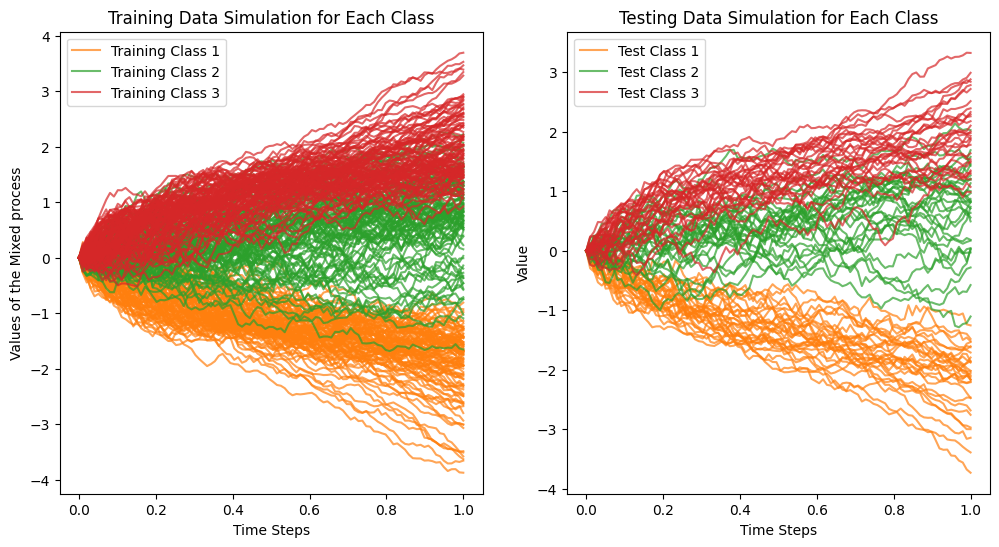


-----Begining Drift estimation-----


Drift Loop:   0%|          | 0/3 [00:00<?, ?it/s]


-----Class number 1 -----
Value of K : 256
Epoch number : 0, Value of the loss : 59.458919525146484
Epoch number : 10, Value of the loss : 56.633277893066406
Epoch number : 20, Value of the loss : 56.101051330566406
Epoch number : 30, Value of the loss : 55.9759407043457
Epoch number : 40, Value of the loss : 55.93552017211914
Epoch number : 50, Value of the loss : 55.91733169555664
Epoch number : 60, Value of the loss : 55.907379150390625
Epoch number : 70, Value of the loss : 55.90068817138672
Epoch number : 80, Value of the loss : 55.8957405090332
Epoch number : 90, Value of the loss : 55.891815185546875
-----Selected K value : 256
Epoch number : 0, Value of the loss : 60.73242950439453
Epoch number : 10, Value of the loss : 60.23764419555664
Epoch number : 20, Value of the loss : 60.1044921875
Epoch number : 30, Value of the loss : 60.07292175292969
Epoch number : 40, Value of the loss : 60.06332015991211
Epoch number : 50, Value of the loss : 60.05937576293945
Epoch number : 60, 

Drift Loop:   0%|          | 0/3 [00:37<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Prediction
t0 = 0;T = 1;x0 = 0;n = 100
Ni_train_list = np.array([100,100,100])
Ni_test_list = np.array([30,30,30])
labels = np.array([1,2,3])
theta = np.array([-4,1,4])

# Prediction
Xtrain, ytrain, Xtest, ytest = simulation_sde(t0, T, x0, n, Ni_train_list,
                                              Ni_test_list, labels,
                                              b,sigma, theta)
Xtrain = torch.from_numpy(Xtrain).float()
ytrain = torch.from_numpy(ytrain).float()
Xtest = torch.from_numpy(Xtest).float()
ytest = torch.from_numpy(ytest).float()

SetK = torch.from_numpy(2**np.array([8])).int()
predicted_labels, predicted_labels_train = sde_classif_NN(Xtrain, ytrain, Xtest,
                                                          ytest, SetK, labels,
                                                          num_epochs = 1000,
                                                          batch_size = 100,
                                                          overfit_check = True,
                                                          plot = True)

#### Misclassification analysis

##### Accuracy

In [ ]:
def accuracy (y_real, predictions) :
    return np.mean([y == pred for y,pred in zip(y_real,predictions)])

In [ ]:
print('Accuracy of the estimated classifier : ',accuracy(ytest, predicted_labels)*100,'%')
print('Misclassification ratio of the estimated classifier : ',(1-accuracy(ytest, predicted_labels))*100,'%')

Accuracy of the estimated classifier :  32.22222222222222 %
Misclassification ratio of the estimated classifier :  67.77777777777779 %
